# <font color='#d50283'>IT Academy - Ciència de Dades (online)</font>
## Tasca M5 T02:   
### Exercicis de Train-Test amb ScikitLearn a partir d'un dataset amb informació sobre les vivendes de Houston.
### Juan Javier Hidalgo Gómez

### <font color='#d50283'>- Generación del Entorno de trabajo</font>

<font color='#00913f'>*Descripción de las variables:*</font>  
* **CRIM**: tasa de criminalidad per cápita por ciudad
* **ZN**: proporción de terreno residencial zonificado para lotes de más de 25,000 pies cuadrados.
* **INDUS**: proporción de acres comerciales no minoristas por ciudad.
* **CHAS**: variable ficticia del río Charles (1 si el tramo limita con el río; 0 en caso contrario)
* **NOX**: concentración de óxidos nítricos (partes por 10 millones)
* **RM**: número promedio de cuartos por vivienda
* **AGE**: proporción de unidades ocupadas por propietarios construidas antes de 1940
* **DIS**: distancias ponderadas a cinco centros de empleo
* **RAD**: índice de accesibilidad a las carreteras radiales
* **TAX**: tasa de impuestos sobre la propiedad de valor total por cada $10,000
* **PTRATIO**: ratio alumno-profesor por localidad
* **B**: 1000(Bk - 0.63)^2 donde Bk es la proporción de negros por ciudad
* **LSTAT**: % estado más bajo de la población
* **MEDV**: valor medio de las viviendas ocupadas por sus propietarios en miles de dólares


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from itertools import zip_longest
from colorama import init, Fore, Back, Style

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, PowerTransformer,normalize
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,MinMaxScaler,Normalizer,Binarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import pylab
from scipy.stats import ttest_1samp, ttest_ind, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import shapiro,pearsonr,normaltest,anderson,boxcox


# Configuration
%matplotlib inline
set_config(display='diagram')

import warnings
warnings.filterwarnings('ignore')


#Variables genéricas:
path=r'C:\Users\Nitropc\IT Academy\Data Science\DS_Sprint_05\Fuente de Datos\housing data.csv'

#Funciones
# Intento de Mecanizar acciones/herramientas para el analisis de cualquier DataSet
# Guardar información de los pasos EDA

def GrabarFicheros (fichero,texto):
    ocurrencias=str.split(path,"/")
    duppath = ''
    for s in ocurrencias[:-1]:duppath += s + '/' 
    try:
        file=open(f"{duppath}{fichero}","a", encoding='utf-8')
        file.write(texto+"\n") 
    except IOError:
        file=open(f"{duppath}{fichero}","w", encoding='utf-8')
        file.write(texto+"\n")
    file.close()
        
# Eliminar las filas 

def Eliminar_duplicados(dfe):
    file="Duplicados.txt"
    # Número de registros del dataSet antes de eliminar.
    treg=dfe.duplicated().sum()
    df=dfe[dfe.duplicated(keep=False)]
    texto=f"Número de duplicados={treg}"
    GrabarFicheros(file,texto)
    texto=f"Filas Duplicadas={df}"
    GrabarFicheros(file,texto)
    if treg!=0:dfs=dfe.drop_duplicates()
    else: dfs=dfe
    file=""  
    #input("Please press the Enter key to proceed")
    return(dfs)
        

def Eliminar_Nulos(dfe):
    file="Nulos.txt"
    # Número de registros del dataSet antes de eliminar.
    treg=data.isnull().any(axis=1).sum()
    df=dfe[dfe.isnull().any(axis=1)]
    texto=f"Número de Nulos={treg}"
    GrabarFicheros(file,texto)
    texto=f"Filas Nulas={df}"
    GrabarFicheros(file,texto)
    #print(f'Resultado:\n Total de Duplicados={treg}')
    # eliminamos Filas con datos nulos
    #input("Please press the Enter key to proceed")
    if treg!=0:dfs=dfe.dropna(how='all')
    else: dfs=dfe
    file=""     
    
    return(dfs)


#Cuerpo 
#data = pd.read_csv(path,sep=',',encoding='ISO-8859-1')
data = pd.read_csv(path,sep=',',encoding='latin-1')
data.columns=['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
print(Style.BRIGHT +'Análisis Exploratorio de Datos(EDA):\n\nResultado:\n '+Style.RESET_ALL)
print(f'- Total de Registros {data.shape[0]}, Total de atributos {data.shape[1]}.\n')

data=Eliminar_duplicados(data)
data=Eliminar_Nulos(data)

#print(f'Estudio Nulos:\n{data.isna().sum().sort_values(ascending = False)}')
print(f'- Total de Registros una vez eliminados duplicados y Nulos {data.shape[0]}.\n')
print(f'- Tamaño del DataSet: {data.shape} \n')
print(f'- Información del DataSet:\n')
display(data.info())
print(f'- Visualización de diferentes filas al azar:')
display(data.sample(5))
print('- Estadística descriptiva del DataSet:\n')
display(data.describe())
print('- Tabla de Coeficiente de Correlación de nuestro DataSet:\n')
print(Style.BRIGHT +'Nota:')
print('Filtro en la Tabla solo atributos con Negativa/Positiva alta, +/- 0.70) :\n'+Style.RESET_ALL)


Tabla=data.corr()
Coef=0.70

#Código para solo presentar los atributos que tiene un coeficiente +/- 0.7
# Crear un nuevo DataFrame vacío
filtered_df = pd.DataFrame()
numcol=Tabla.shape[1]
vcol=0
borrarindice=[]

for index, row in Tabla.iterrows():
    vcol=0
    for column in Tabla.columns:
        val=Tabla[column][index]
    # Verificar si el nombre de la columna contiene una palabra/valor númerico específico
        if (val <= -Coef) or (val >= Coef and val < 1) :
        # Agregar la columna al nuevo DataFrame
            filtered_df[column] = Tabla[column]
        else: vcol=vcol+1
    # Guardamos el índice para despues borrarlo, sí hemos recorrido todas las columnas y no
    # hemos encontrado nuestro valor
    if vcol==numcol: borrarindice.append(index)
        
# borramos aquellas filas que no hemos tenido el valor buscado.
filtered_df=filtered_df.drop(index=borrarindice,axis=0)           
        
def text_format(val):
    color = 'salmon' if (val <= -Coef) or (val >= Coef and val < 1) else 'white'
    return 'background-color: %s' % color



filtered_df.style.applymap(text_format)

# Estudiar tambien el sns.heatmap, si puedo hacer lo mismo


Análisis Exploratorio de Datos(EDA):

Resultado:
 
- Total de Registros 505, Total de atributos 14.

- Total de Registros una vez eliminados duplicados y Nulos 505.

- Tamaño del DataSet: (505, 14) 

- Información del DataSet:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     505 non-null    float64
 1   ZN       505 non-null    float64
 2   INDUS    505 non-null    float64
 3   CHAS     505 non-null    int64  
 4   NOX      505 non-null    float64
 5   RM       505 non-null    float64
 6   AGE      505 non-null    float64
 7   DIS      505 non-null    float64
 8   RAD      505 non-null    int64  
 9   TAX      505 non-null    float64
 10  PTRATIO  505 non-null    float64
 11  B        505 non-null    float64
 12  LSTAT    505 non-null    float64
 13  MEDV     505 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.4 KB


None

- Visualización de diferentes filas al azar:


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
346,0.01870,85.0,4.15,0,0.4290,6.516,27.7,8.5353,4,351.0,17.9,392.43,6.36,23.1
446,9.92485,0.0,18.10,0,0.7400,6.251,96.6,2.1980,24,666.0,20.2,388.52,16.44,12.6
468,13.07510,0.0,18.10,0,0.5800,5.713,56.7,2.8237,24,666.0,20.2,396.90,14.76,20.1
198,0.03150,95.0,1.47,0,0.4030,6.975,15.3,7.6534,3,402.0,17.0,396.90,4.56,34.9
202,0.03510,95.0,2.68,0,0.4161,7.853,33.2,5.1180,4,224.0,14.7,392.78,3.81,48.5


- Estadística descriptiva del DataSet:



,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,3.620667,11.350495,11.154257,0.069307,0.554728,6.284059,68.581584,3.794459,9.566337,408.459406,18.461782,356.594376,12.668257,22.529901
std,8.608572,23.343704,6.855868,0.254227,0.115990,0.703195,28.176371,2.107757,8.707553,168.629992,2.162520,91.367787,7.139950,9.205991
min,0.009060,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082210,0.000000,5.190000,0.000000,0.449000,5.885000,45.000000,2.100000,4.000000,279.000000,17.400000,375.330000,7.010000,17.000000
50%,0.259150,0.000000,9.690000,0.000000,0.538000,6.208000,77.700000,3.199200,5.000000,330.000000,19.100000,391.430000,11.380000,21.200000
75%,3.678220,12.500000,18.100000,0.000000,0.624000,6.625000,94.100000,5.211900,24.000000,666.000000,20.200000,396.210000,16.960000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


- Tabla de Coeficiente de Correlación de nuestro DataSet:

Nota:
Filtro en la Tabla solo atributos con Negativa/Positiva alta, +/- 0.70) :



,NOX,DIS,TAX,INDUS,AGE,RAD,MEDV,LSTAT
INDUS,0.764556,-0.708848,0.720561,1.000000,0.645543,0.594167,-0.484126,0.602737
NOX,1.000000,-0.769221,0.668141,0.764556,0.731461,0.611758,-0.427295,0.591262
AGE,0.731461,-0.747872,0.506527,0.645543,1.000000,0.456232,-0.376932,0.602782
DIS,-0.769221,1.000000,-0.534492,-0.708848,-0.747872,-0.494798,0.249896,-0.497277
RAD,0.611758,-0.494798,0.910202,0.594167,0.456232,1.000000,-0.381690,0.487608
TAX,0.668141,-0.534492,1.000000,0.720561,0.506527,0.910202,-0.468543,0.543435
LSTAT,0.591262,-0.497277,0.543435,0.602737,0.602782,0.487608,-0.738187,1.000000
MEDV,-0.427295,0.249896,-0.468543,-0.484126,-0.376932,-0.381690,1.000000,-0.738187


> ****Nota:  
    La tabla anterior nos permite observar aquellos atributos que tienen un buen coeficiente de correlación.  Resaltado en un color Salmón se observa esa combinación entre los diferentes atributos +/- 0.7****


In [2]:
def crearhistograma(df):
    sns.set(context='poster',
    style='white',
    palette='dark',
    font='sans-serif', 
    font_scale=0.85, color_codes='r', rc=None)
    rows = 2
    cols = 7

    fig, ax = plt.subplots(nrows = rows , ncols = cols , figsize = (20,15))

    col = df.columns
    index = 0

    for i in range(rows):
        for j in range(cols):
            sns.distplot(df[col[index]], ax = ax[i][j])
            index +=1 

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [3]:
def crearquantile(df):
    sns.set(context='poster',
        style='white',
        palette='dark',
        font='sans-serif', 
        font_scale=0.85, color_codes='r', rc=None)
    
    rows = 2
    cols = 7

    fig, axs = plt.subplots(nrows = rows , ncols = cols , figsize = (20,15))
    index = 0
    col = df.columns
    axs = axs.flatten()
    
    for ax, i in zip(axs.ravel(), col):
        stats.probplot(df[i],dist='norm',plot=ax)
        index +=1
        ax.set_title("Gráfica Q-Q "+ str(i))
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [4]:
#Bucle para Spahiro-Wilk a todas las columnas del dataset
def crearShapiro(df):        
    alfa=0.05
    print(Style.BRIGHT +'Resultado del Test de Hipótesis:\n'+Style.RESET_ALL)
    print(Style.BRIGHT + Fore.GREEN+'Shapiro-Wilk: \n'+Style.RESET_ALL)
        
    for columns in df:        
        stat, p = shapiro(df[columns])
        print(Style.BRIGHT + Fore.BLACK+f'{columns}:'+Style.RESET_ALL)
        print(Fore.RESET+'t-statistic = %.3f\np-value = %.6f' % (stat, p))
        if p > alfa:
            print(Fore.BLUE+f'No podemos rechazar Ho con un nivel de significancia del {alfa*100} %,\nel atributo tiene una distribucción normal(Probably Gaussian).\n')
        else:
            print(Fore.RED+f'Podemos rechazar Ho con un nivel de significancia del {alfa*100} %,\nel atributo no tiene una distribucción normal(Not Probably Gaussian).\n')
    print(Fore.RESET+'---------- \n')

<font color='#00913f'>*Prueba de Contraste de Normalidad de Nuestro DataSet:*</font>  
   
- Gráfica de Histograma.
- Gráfico Quantile-Quantile.
- Prueba Shapiro-Wilks.



- Gráfica Histograma de los diferentes atributos:
 


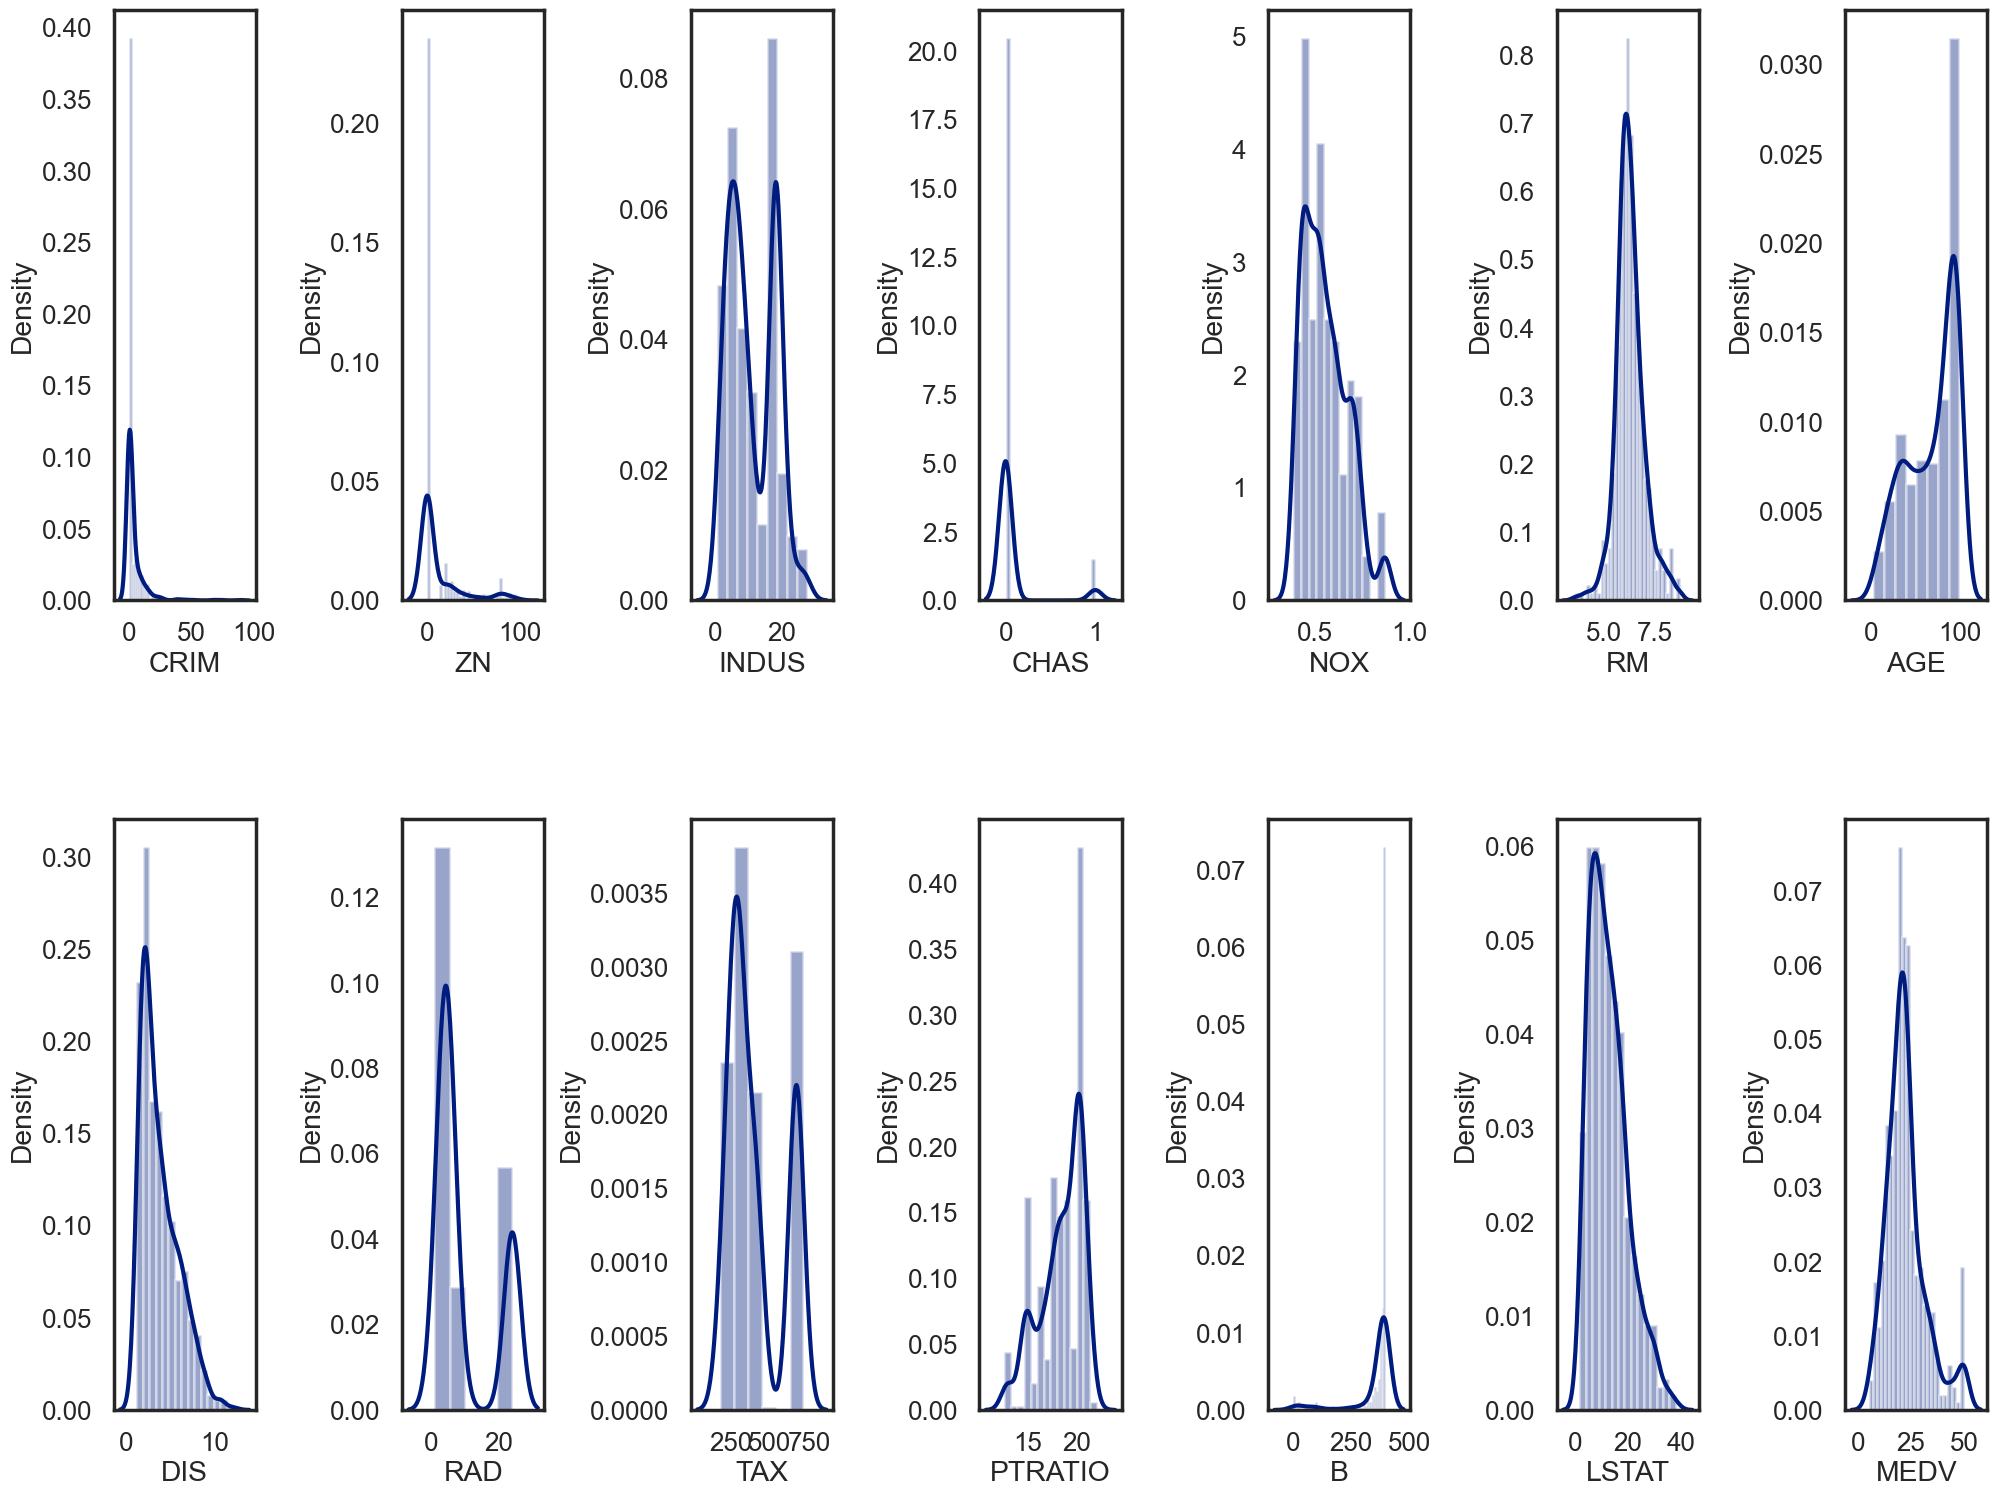

In [5]:
#print(Style.BRIGHT +'\nPruebas de Contraste de Normalidad:\n '+Style.RESET_ALL)
print('\n- Gráfica Histograma de los diferentes atributos:\n ')
crearhistograma(data)
sns.set_theme(style="white", rc=None)

> ****Nota:  
Visualizando los atributos del dataset con la representación gráfica, observamos que el atributo <font color='#d50283'>RM</font> parece una distribución normal.  
Otros atributos <font color='#d50283'>NOX, DIS, LSTAT, MEDV</font> parecen que puedan tener una distribución normal sesgada.   
Lo comprobaremos en los ejercicios propuestos para el sprint.****


- Gráfica Quantile-Quantile:
 


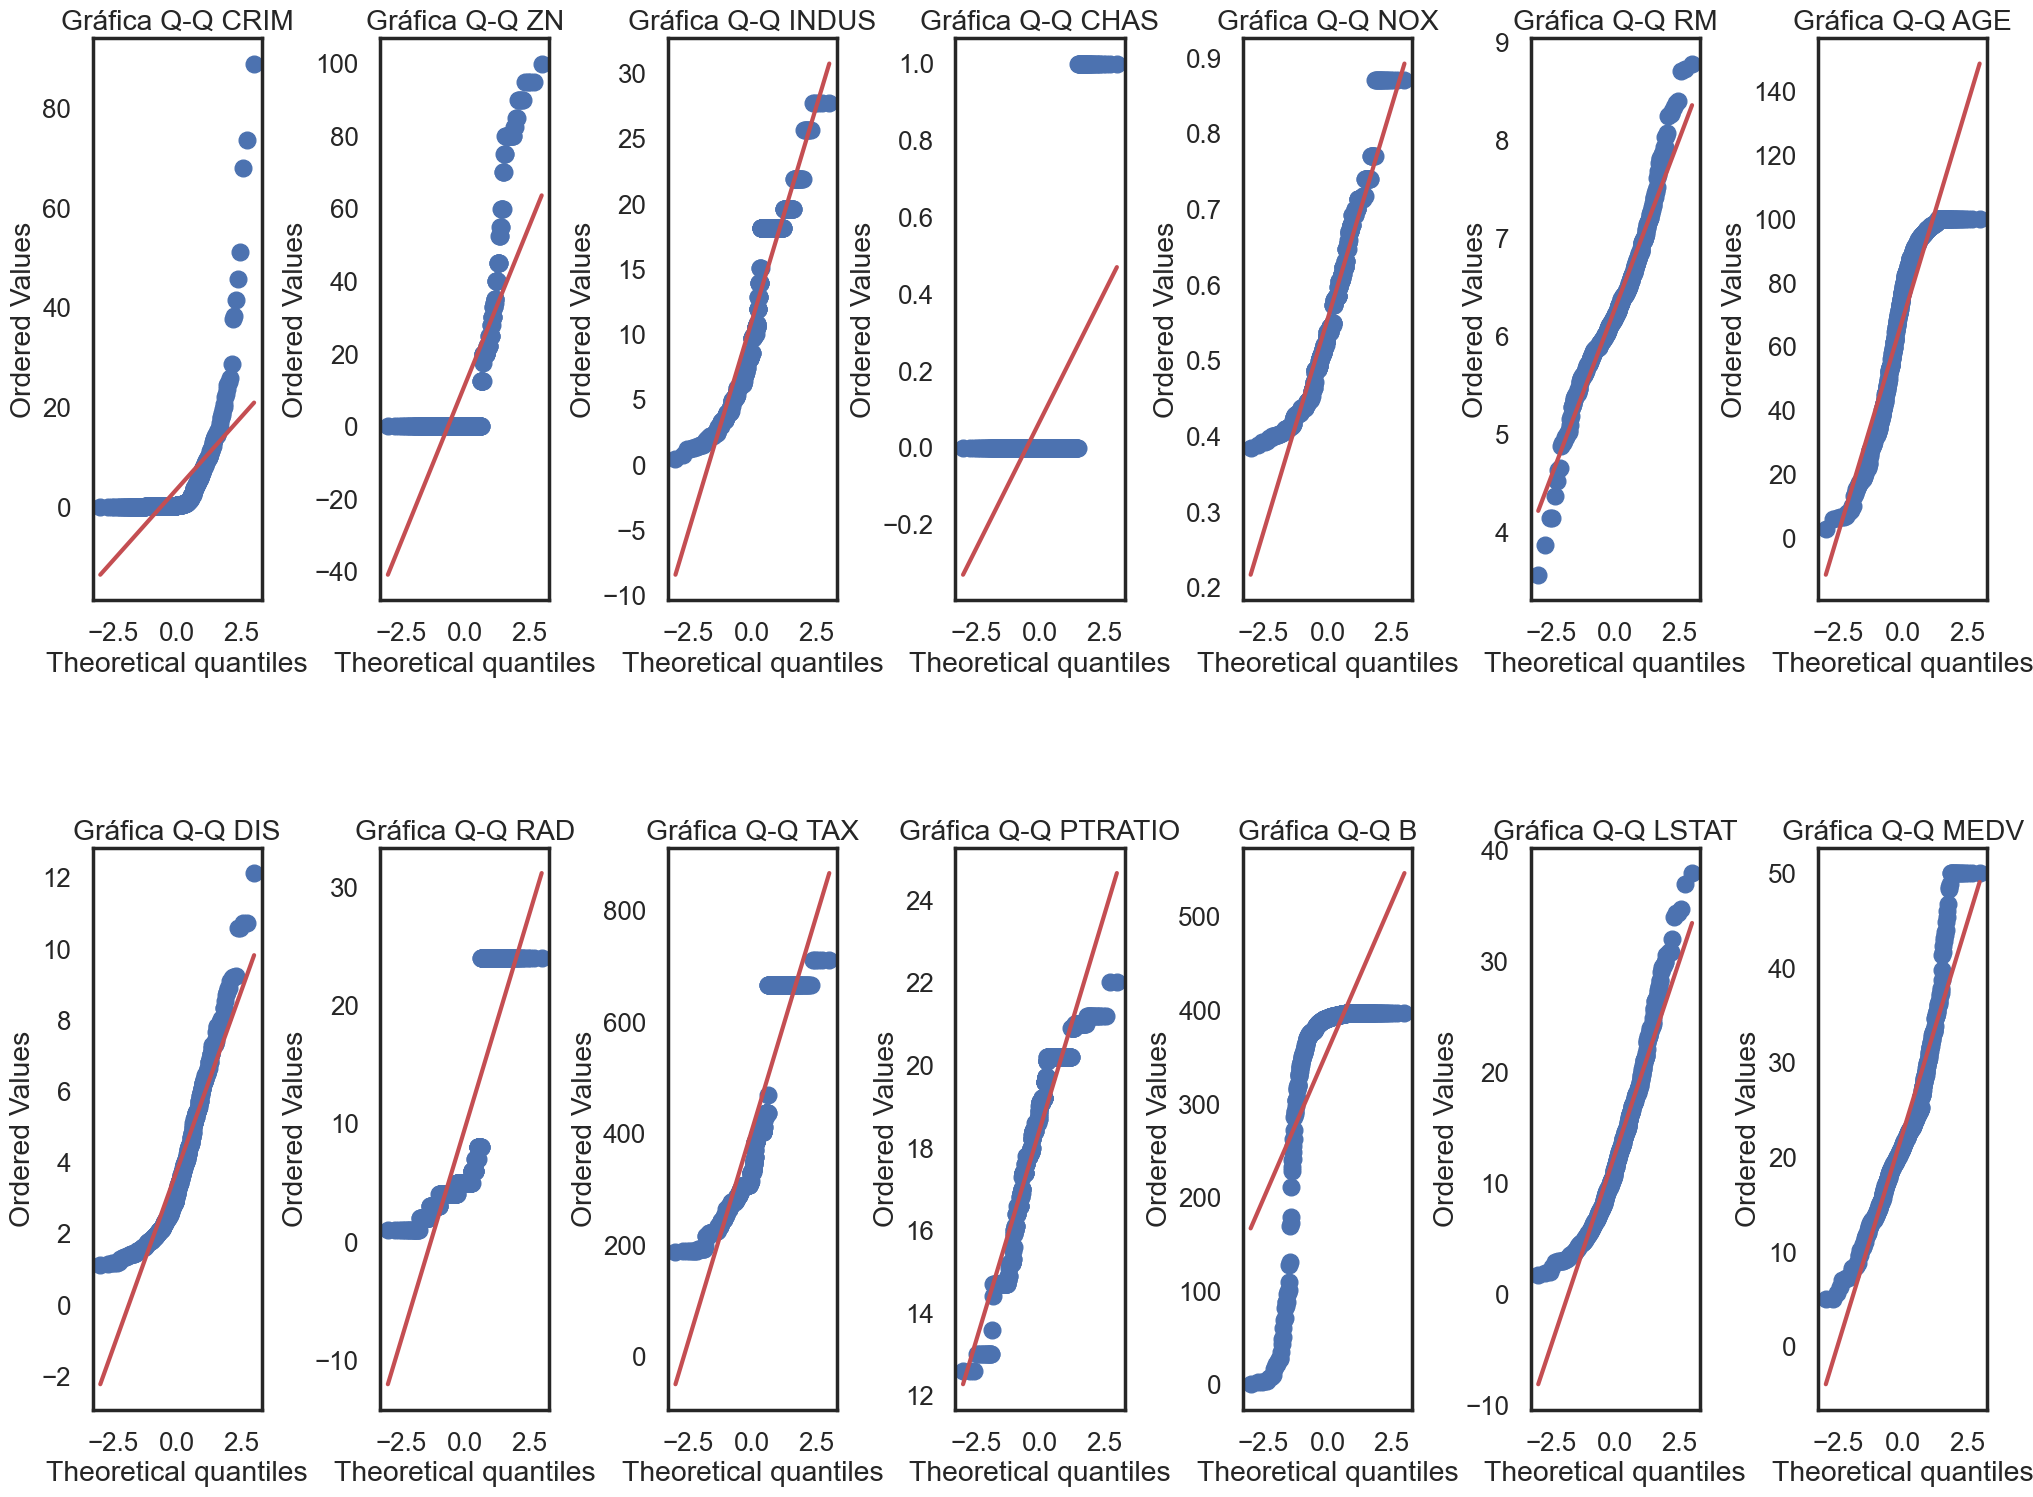

In [6]:
print('\n- Gráfica Quantile-Quantile:\n ')
crearquantile(data)
sns.set_theme(style="white", rc=None)

> ****Nota:  
Con la representación Gráfica Quantile-Quantile, el resultado visual sería igual al que he realizado antes, el atributo <font color='#d50283'>RM, NOX, DIS, LSTAT, MEDV</font> parece que se alinean cerca de la diagonal, aunque sus extremos se abren. Cuanto más se alejen de la línea, menos probable será que nuestros datos sigan una distribución normal.  
Lo comprobaremos en los ejercicios propuestos para el sprint.****

In [7]:
print('\n- Prueba Shapiro-Wilk:\n ')
crearShapiro(data)
sns.set_theme(style="white", rc=None)


- Prueba Shapiro-Wilk:
 
Resultado del Test de Hipótesis:

Shapiro-Wilk: 

CRIM:
t-statistic = 0.450
p-value = 0.000000
Podemos rechazar Ho con un nivel de significancia del 5.0 %,
el atributo no tiene una distribucción normal(Not Probably Gaussian).

ZN:
t-statistic = 0.555
p-value = 0.000000
Podemos rechazar Ho con un nivel de significancia del 5.0 %,
el atributo no tiene una distribucción normal(Not Probably Gaussian).

INDUS:
t-statistic = 0.900
p-value = 0.000000
Podemos rechazar Ho con un nivel de significancia del 5.0 %,
el atributo no tiene una distribucción normal(Not Probably Gaussian).

CHAS:
t-statistic = 0.275
p-value = 0.000000
Podemos rechazar Ho con un nivel de significancia del 5.0 %,
el atributo no tiene una distribucción normal(Not Probably Gaussian).

NOX:
t-statistic = 0.936
p-value = 0.000000
Podemos rechazar Ho con un nivel de significancia del 5.0 %,
el atributo no tiene una distribucción normal(Not Probably Gaussian).

RM:
t-statistic = 0.961
p-value = 0.00000

> ****Nota:  
Ninguno de los atributos pasan la prueba de Shapiro.  Podemos determinar con las pruebas de contraste de normalidad realizadas de nuestro DataSet que ningún atributo tiene una distribución Normal(Gaussiana).****

<font color='#FF0515'>*Link de Ayuda:*</font>   
- <font color='#00913f'>*Preprocessing*</font> [Link](<https://scikit-learn.org/stable/modules/preprocessing.html>)  
- <font color='#00913f'>*Master Class*</font> [Link](<https://github.com/aina1997/MasterClassDS/tree/main/Introducci%C3%B3%20a%20la%20Intel%C2%B7lig%C3%A8ncia%20artificial>)
- <font color='#00913f'>*Open Chat AI*</font> [Link](<https://chat.openai.com/chat>)
- <font color='##08a22a'>*Rocio Chavez Ciencia de Datos*</font> [Link](<https://www.youtube.com/watch?v=YOyiAzJv8Qg>)   
- <font color='##08a22a'>*Normalización de Datos en Python*</font> [Link](<https://www.youtube.com/watch?v=MuebTNdX0y0&list=PLUofJx5RUeFqAIVdzfnJayenwZFEGtCmg&index=43>)   
- <font color='##08a22a'>*Pruebas de Normalidad en Python*</font> [Link](<https://www.youtube.com/watch?v=hXonZjU9BWo&list=PLUofJx5RUeFqAIVdzfnJayenwZFEGtCmg&index=16>)    


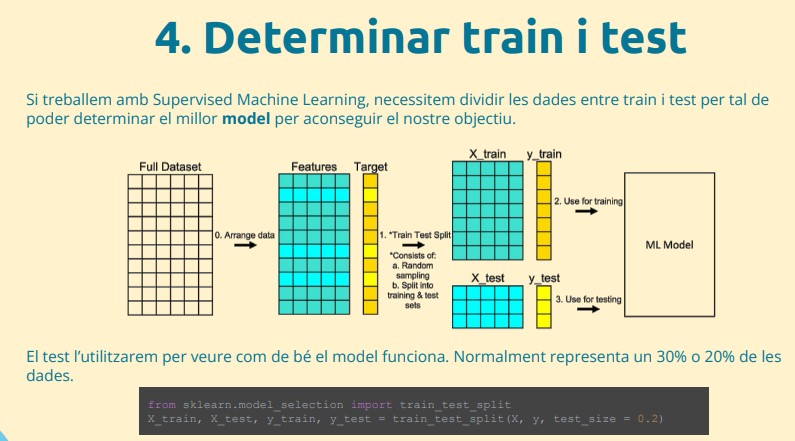

### <font color='#d50283'>- Exercici 1</font>
Parteix el conjunt de dades adjunt en train i test. Estudia els dos conjunts per separat, a nivell descriptiu.

També adjunt trobaràs una descripció de les diferents variables del dataset.

   
****Utilizo los siguientes atributos para realizar el Train/Test.****  
Creamos nuestro dataset de Train y Test:    
- features = ['RM','NOX','DIS','TAX','INDUS','AGE','RAD','LSTAT']  
- target = ['MEDV']

In [8]:
# Creamos nuestro dataset de Train y Test
features = ['RM','NOX','DIS','TAX','INDUS','AGE','RAD','LSTAT']
target = ['MEDV']
#features = columnas
#Voy a utilizar los atributos que han tenido un coeficiente de correlación +/- 0.7 y RM que parecia
#una distribución normal

x = data.loc[:, features]
#target 
y = data.loc[:, target]
    
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size =0.2, 
                                                    random_state = 42) 
# random_state = 42, siempre coge la misma partición


print(Style.BRIGHT +'Estudio del Conjunto de Datos:\n\nResultado:\n '+Style.RESET_ALL) 
print(Fore.GREEN+'Conjunto de Datos Train y Test (x e y):'+Style.RESET_ALL)
print(f'- Total de Registros y atributos, X_train: {X_train.shape}')
print(f'- Total de Registros y atributos, X_test: {X_test.shape}')
print(f'- Total de Registros y atributos, y_train: {y_train.shape}')
print(f'- Total de Registros y atributos, y_test: {y_test.shape}')


print(Style.BRIGHT +'Estudio del Conjunto de Datos:\n\nResultado:\n '+Style.RESET_ALL)
print(Fore.GREEN+'Conjunto de Datos X_Train:'+Style.RESET_ALL)
print('- Estadística descriptiva del DataSet:\n')
display(X_train.describe().T)
print(Fore.GREEN+'Conjunto de Datos X_Test:'+Style.RESET_ALL)
print('- Estadística descriptiva del DataSet:\n')
display(X_test.describe().T)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Estudio del Conjunto de Datos:

Resultado:
 
Conjunto de Datos Train y Test (x e y):
- Total de Registros y atributos, X_train: (404, 8)
- Total de Registros y atributos, X_test: (101, 8)
- Total de Registros y atributos, y_train: (404, 1)
- Total de Registros y atributos, y_test: (101, 1)
Estudio del Conjunto de Datos:

Resultado:
 
Conjunto de Datos X_Train:
- Estadística descriptiva del DataSet:



,count,mean,std,min,25%,50%,75%,max
RM,404.0,6.312012,0.716811,3.8630,5.88775,6.2115,6.63675,8.7800
NOX,404.0,0.558806,0.118743,0.3850,0.45200,0.5380,0.64700,0.8710
DIS,404.0,3.791142,2.148594,1.1296,2.06470,3.0974,5.25535,12.1265
TAX,404.0,410.279703,168.069416,187.0000,281.00000,336.0000,666.00000,711.0000
INDUS,404.0,11.136213,6.918757,0.4600,5.13000,8.5600,18.10000,27.7400
AGE,404.0,68.307921,28.287495,2.9000,43.20000,77.7500,93.80000,100.0000
RAD,404.0,9.700495,8.709933,1.0000,4.00000,5.0000,24.00000,24.0000
LSTAT,404.0,12.572995,7.126223,1.7300,6.89250,11.3950,16.67250,37.9700


Conjunto de Datos X_Test:
- Estadística descriptiva del DataSet:



,count,mean,std,min,25%,50%,75%,max
RM,101.0,6.172248,0.636964,3.5610,5.8740,6.1290,6.4590,8.0340
NOX,101.0,0.538415,0.103191,0.3940,0.4480,0.5240,0.5970,0.8710
DIS,101.0,3.807726,1.945858,1.3163,2.3682,3.6519,5.0141,10.5857
TAX,101.0,401.178218,171.505533,188.0000,277.0000,311.0000,666.0000,711.0000
INDUS,101.0,11.226436,6.631390,0.7400,6.0600,9.9000,18.1000,27.7400
AGE,101.0,69.676238,27.839684,6.0000,46.3000,77.3000,95.4000,100.0000
RAD,101.0,9.029703,8.720614,1.0000,4.0000,5.0000,8.0000,24.0000
LSTAT,101.0,13.049307,7.217658,1.9800,7.7300,11.2800,17.6000,34.4100


(404, 8) (101, 8) (404, 1) (101, 1)


>****Nota:   
Los valores estadisticos del Test y train son similares.****

Observamos gráficamente también los dos Dataset resultantes X_train y X_test:

Gráfica del conjunto de Datos X_train:



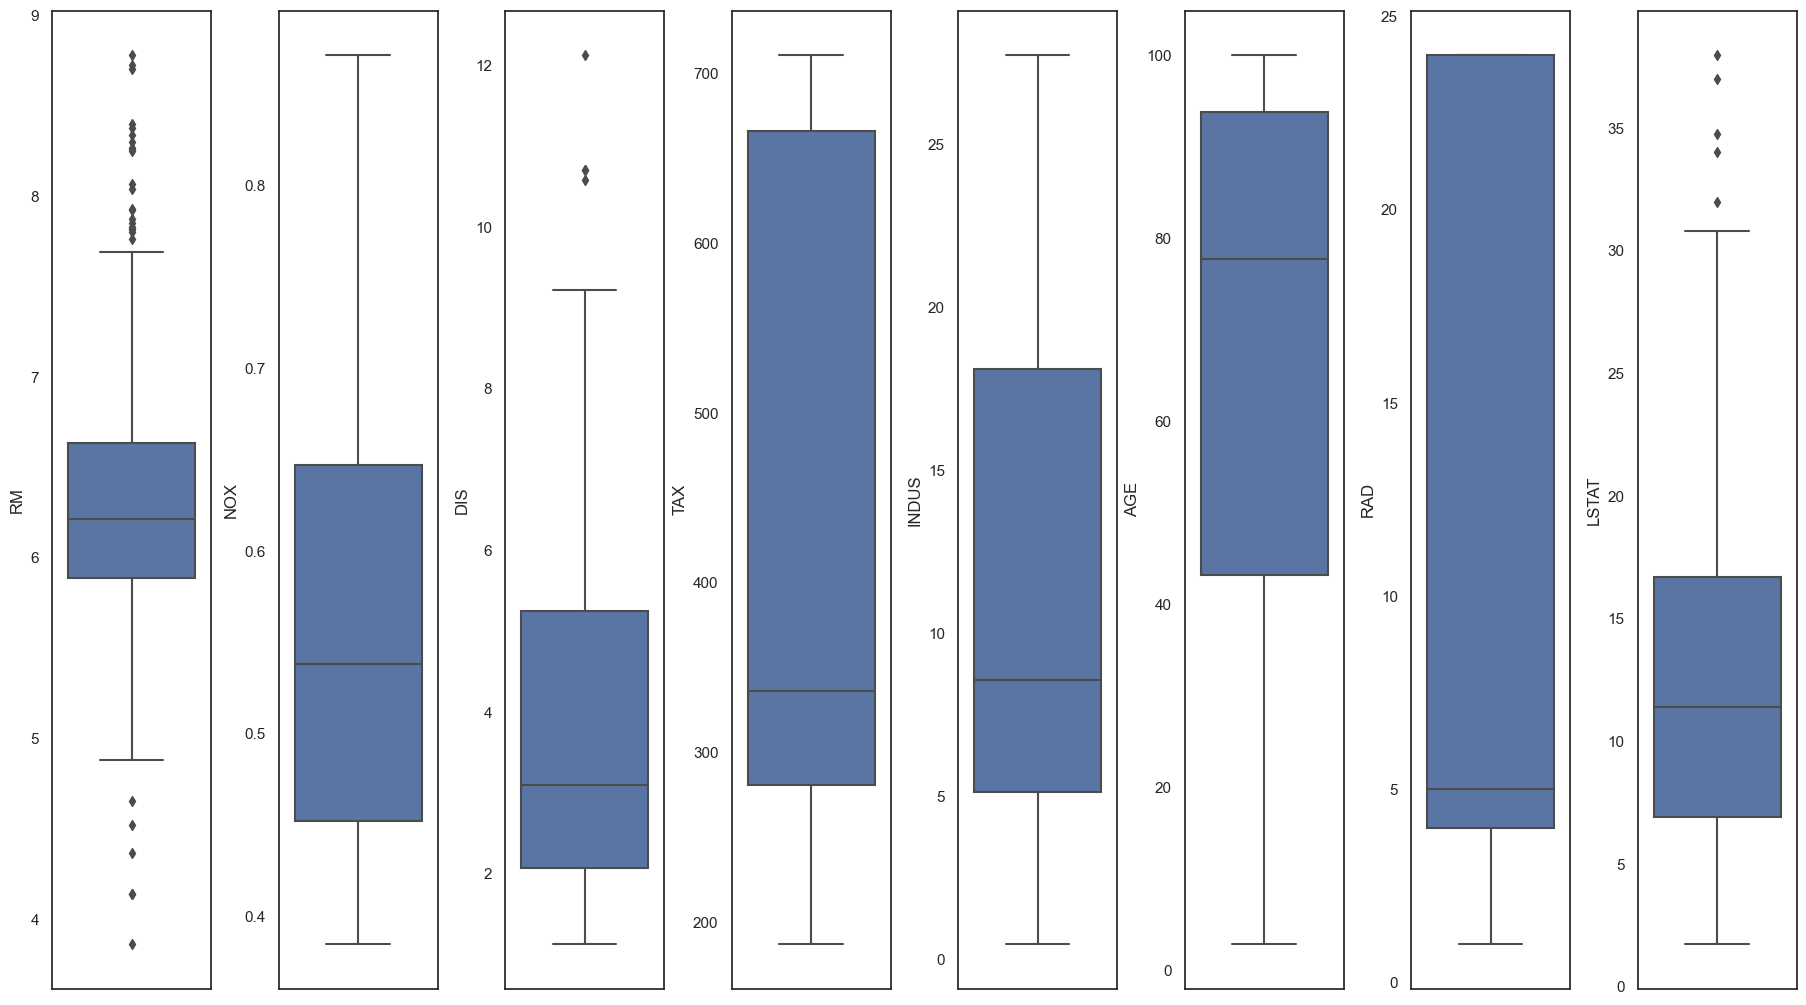

In [9]:
print(Fore.GREEN+'Gráfica del conjunto de Datos X_train:\n'+Style.RESET_ALL)
fig, axs = plt.subplots(ncols=X_train.shape[1], nrows=1, figsize=(18, 10))
index = 0
axs = axs.flatten()
for k,v in X_train.items():
    sns.boxplot(y=k, data=X_train, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Gráfica del conjunto de Datos X_test:



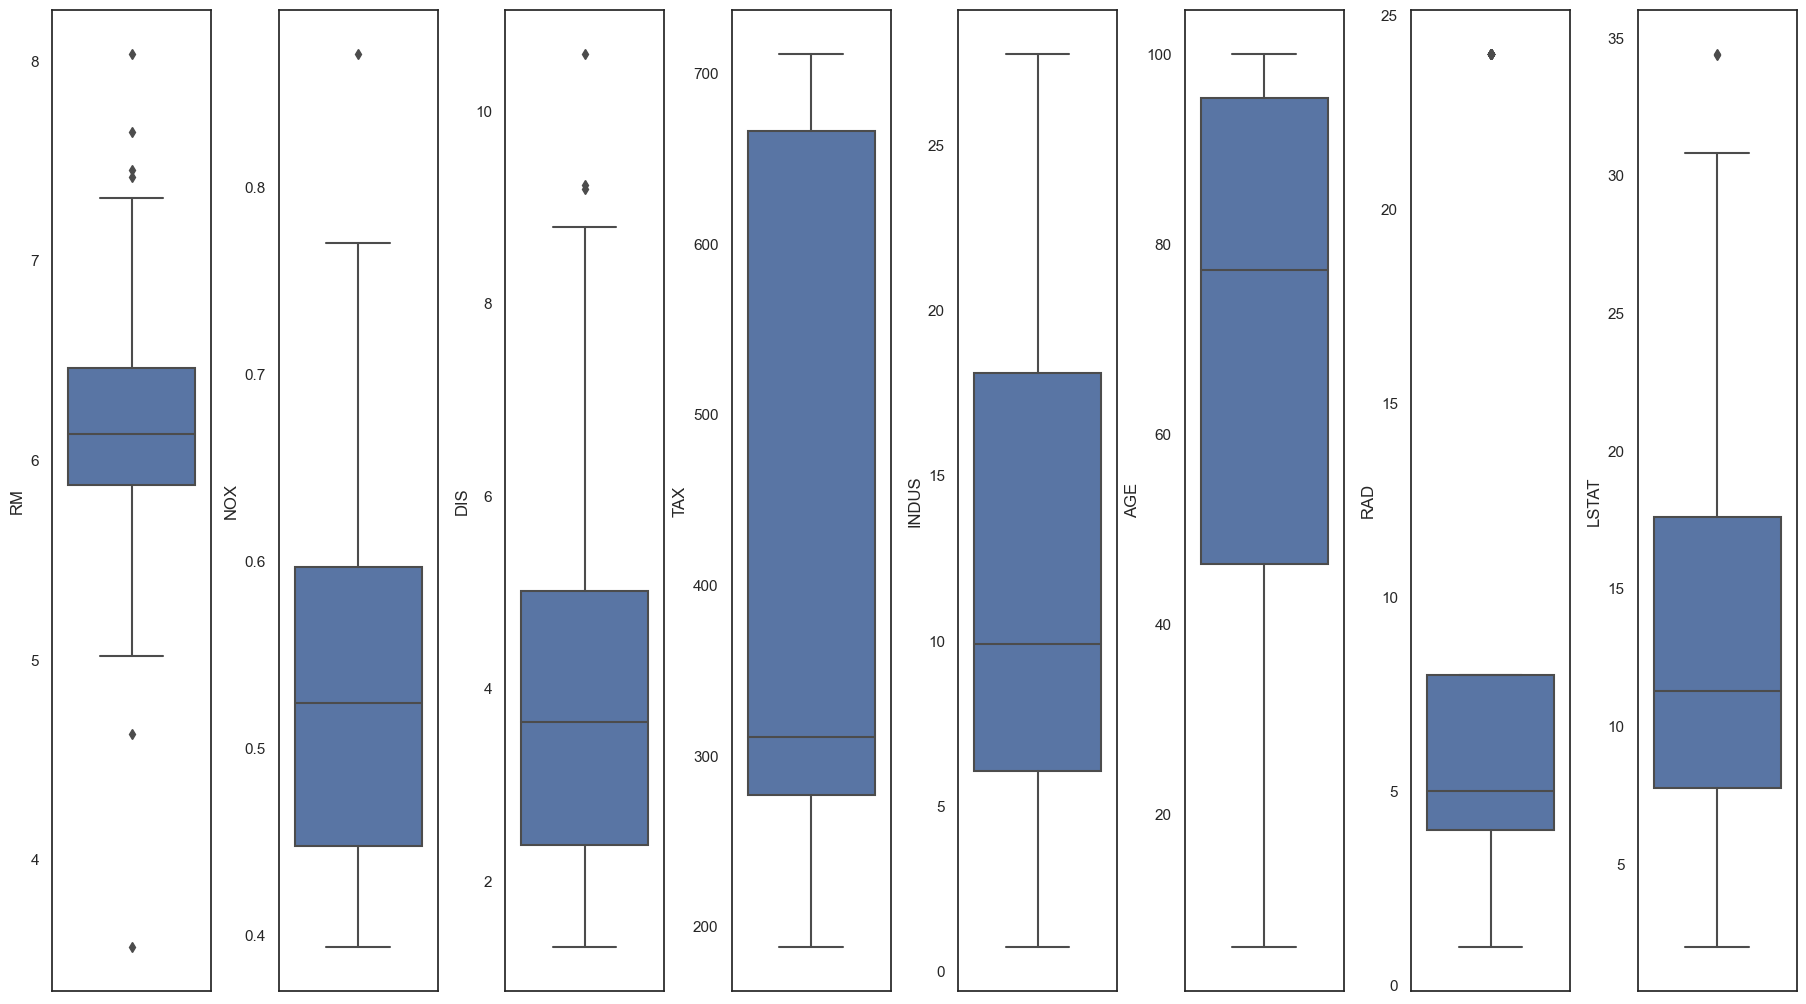

In [10]:
print(Fore.GREEN+'Gráfica del conjunto de Datos X_test:\n'+Style.RESET_ALL)
fig, axs = plt.subplots(ncols=X_test.shape[1], nrows=1, figsize=(18, 10))
index = 0
axs = axs.flatten()
for k,v in X_test.items():
    sns.boxplot(y=k, data=X_test, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

>****Nota:  
Al comparar los atributos entre el dataset de X_train y el de X_test, podemos observar que las formas son bastante parecidas, excepto el atributo 'RAD'.****

In [11]:
display(X_train.RAD.unique())
display(X_train.RAD.nunique())

array([ 5, 24,  4,  3,  8,  6,  7,  2,  1], dtype=int64)

9

Realizamos el mismo estudio para la variable de salida y_train e y_test:
    

Gráficas del conjunto de Datos y_train e y_test:



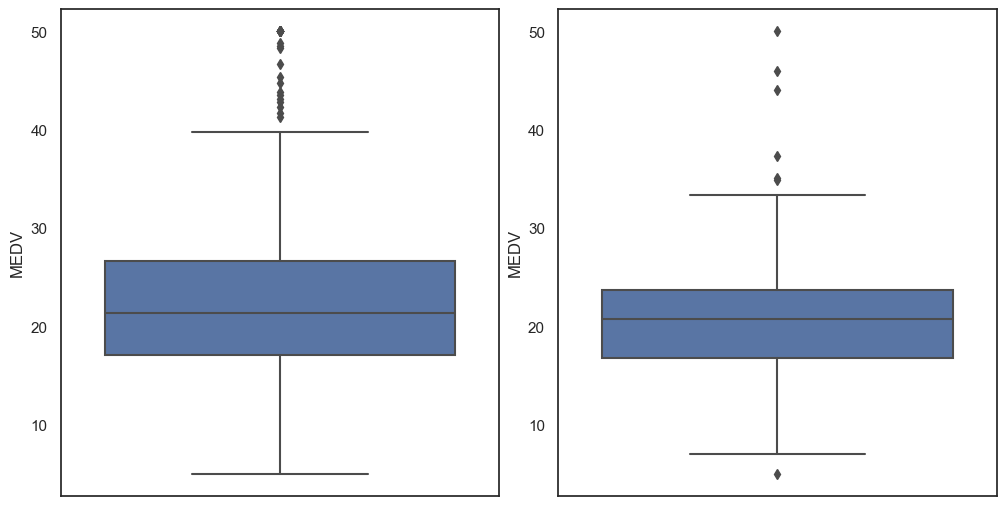

In [12]:
#Dibujo ytrain e ytest
print(Fore.GREEN+'Gráficas del conjunto de Datos y_train e y_test:\n'+Style.RESET_ALL)
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
index = 0
axs = axs.flatten()

for k,v in y_train.items():
    sns.boxplot(y=k, data=y_train, ax=axs[0])
    sns.boxplot(y=k, data=y_test, ax=axs[1])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [13]:
def compararDensidad(train, test, atributo):
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(7, 4))
    fig.suptitle('Comparación de y_train & y_test Data: '+ atributo)
    sns.kdeplot(data=train, x=atributo, ax=ax1).set_ylabel('Densidad Train')
    sns.kdeplot(data=test, x=atributo, ax=ax2).set_ylabel('Densidad Test')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

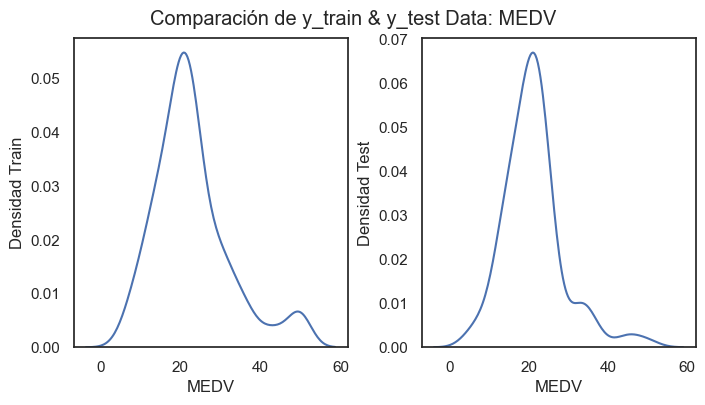

In [14]:
compararDensidad(y_train,y_test, 'MEDV')

> ****Nota:  
Visualmente las dos gráficas son muy parecidas, podemo pensar que ha realizado un split bastante correcto.****

### <font color='#d50283'>- Exercici 2</font>
Aplica algun procés de transformació (estandarditzar les dades numèriques, crear columnes dummies, polinomis...).

Análisis de la distribución normal (Gaussian) de los diferentes atributos de nuestro dataset original(data), para poder realizar una estandarización:

> ****Nota:  
En la pruebas de contraste que se realizó en el estudio del DataSet genérico, ninguno de los atributos pasaron dicha prueba.  Podemos determinar que nuestro DataSet no tiene ningún atributo con una distribución Normal(Gaussiana).  Como la distribución no es normal haremos un proceso de transformación de Normalización****

Normalización:   
- <font color='#00913f'>*Normalize*</font> [Link](<https://www.digitalocean.com/community/tutorials/normalize-data-in-python>)  

#### <font color='#00913f'>*Escalado de variables*</font>  

In [15]:
# Escalar
# Para probar diferentes atributos
print(features)


# atributo=X_train['RM']
# No informa de un error
# Reshape your data either using array.reshape(-1, 1) 
#if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
# definición datos

#solución 1
name='RM'
atributo=X_train[name].values.reshape([X_train[name].values.shape[0],1])
Tatributo=X_test[name].values.reshape([X_test[name].values.shape[0],1])
print(atributo.shape,Tatributo.shape)




['RM', 'NOX', 'DIS', 'TAX', 'INDUS', 'AGE', 'RAD', 'LSTAT']
(404, 1) (101, 1)


**Utilizamos standardization:**   
El escalador <font color='##08a22a'>*sklearn.preprocessing.StandardScaler*</font> [Link](<https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler>)   
La estandarización de conjuntos de datos es un requisito común para muchos estimadores de aprendizaje automático implementados en scikit-learn; podrían comportarse mal si las características individuales no se parecen más o menos a los datos estándar distribuidos normalmente: gaussiana con media cero y varianza unitaria .

En la práctica, a menudo ignoramos la forma de la distribución y simplemente transformamos los datos para centrarlos eliminando el valor medio de cada característica, luego lo escalamos dividiendo las características no constantes por su desviación estándar.

$$ z =\frac{(x - u)}{s} $$

Donde "x" es el valor original, "x_min" es el valor mínimo del conjunto de datos y "x_max" es el valor máximo del conjunto de datos.

In [16]:
print(f'Cálculo de la media {name}:',atributo.mean().round(2))
print(f'Cálculo de la desviación {name}:',atributo.std().round(2)) 
# define min max scaler
standar = StandardScaler()
# transform data
standar_atributo = standar.fit_transform(atributo)
print(f'Cálculo de la media {name} transformado:',standar_atributo.mean().round(2)) 
print(f'Cálculo de la desviación {name} transformado:',standar_atributo.std().round(2)) 
df_standar = pd.DataFrame(standar_atributo)
df_standar.columns=[name+'_std']
#df_standar.describe().round()
#stat, p = shapiro(df_standar)
#print(Fore.RESET+'t-statistic = %.3f\np-value = %.10f' % (stat, p))
#stat, p = normaltest(atributo)
#print(Fore.RESET+'t-statistic = %.3f\np-value = %.10f' % (stat, p))


Cálculo de la media RM: 6.31
Cálculo de la desviación RM: 0.72
Cálculo de la media RM transformado: 0.0
Cálculo de la desviación RM transformado: 1.0


> ***Nota:  
Aunque lo habiamos comentado al principio de este ejercicio, que no cumple una distribucción normal,.  Utilizamos la estandarización para comprobar el comportamiento de este atributo. Podemos observar, que la función la realiza correctamente, llevando tanto la media como la desviación estandar, la $\tilde{x}=0$ y $σ=1$.***

**Utilizamos RobustScaler:**   
El escalador <font color='##08a22a'>*sklearn.preprocessing.RobustScaler*</font> [Link](<https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html>)   
Escale características usando estadísticas que son robustas para los valores atípicos.
                                                                                         
Este escalador elimina la mediana y escala los datos de acuerdo con el rango de cuantiles (el valor predeterminado es IQR: rango intercuartílico). El IQR es el rango entre el primer cuartil (cuartil 25) y el tercer cuartil (cuartil 75).  
                                                                                         


In [17]:
#print(f'Cálculo de la media {name}:',atributo.mean().round(2))
#print(f'Cálculo de la desviación {name}:',atributo.std().round(2)) 
# define min max scaler
Robus = RobustScaler()
# transform data
Robus_atributo = Robus.fit_transform(atributo)

df_Robus = pd.DataFrame(Robus_atributo)
df_Robus.columns=[name+'_Rob']
#display(df_Robus)
#df_Robus.describe().round()
#stat, p = shapiro(df_Robus)
#print(Fore.RESET+'t-statistic = %.3f\np-value = %.10f' % (stat, p))
#stat, p = normaltest(atributo)
#print(Fore.RESET+'t-statistic = %.3f\np-value = %.10f' % (stat, p))

**Utilizamos MinMaxScaler:**   
El escalador <font color='##08a22a'>*sklearn.preprocessing.MinMaxScaler*</font> [Link](<https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html>)  transforma las características escalándolas a un rango dado, por defecto (0,1), aunque puede ser personalizado. Este tipo de escalado suele denominarse frecuentemente "normalización" de los datos. Aplicando la siguiente fórmula:

$$ x_{scaled} =\frac{(x - x_{min})}{(x_{max} - x_{min})} $$

Donde "x" es el valor original, "x_min" es el valor mínimo del conjunto de datos y "x_max" es el valor máximo del conjunto de datos.

In [18]:
print(f'Cálculo de la media:',atributo.mean())
# define min max scaler
scaler = MinMaxScaler()
# transform data
scaler_atributo = scaler.fit_transform(atributo)
print(f'Cálculo de la media {name} transformado:',scaler_atributo.mean()) 

df_MinMax = pd.DataFrame(scaler_atributo)
df_MinMax.columns=[name+'_Mx']
#df_MinMax.describe()

Cálculo de la media: 6.3120123762376235
Cálculo de la media RM transformado: 0.4980704446283555


**Utilizamos Normalizer:**  
La normalización en el aprendizaje automático se refiere al proceso de escalar las características de entrada a un rango estándar, como [0, 1] o [-1, 1]. Esto se hace para garantizar que todas las características estén en la misma escala y que ninguna característica domine a las demás durante el entrenamiento.  
La clase Normalizer tiene varios parámetros de configuración, como norm, que indica el tipo de normalización a aplicar (por defecto es 'l2', lo que significa que se aplica la normalización euclidiana). Otros valores posibles son 'l1' que aplica normalización de manhattan y 'max' que aplica normalización de máximo.   
Es importante tener en cuenta que la normalización no es necesaria en todos los casos, especialmente en problemas donde los valores de las características ya están en un rango similar, y puede afectar negativamente al rendimiento del modelo si se aplica de manera inadecuada.

In [19]:
# Normalizo la columna

Normal = Normalizer(norm='max')
normalized_atributo = Normal.fit_transform(atributo) 

df_normalized = pd.DataFrame(normalized_atributo)
df_normalized.columns=[name+'_Nor']
#df_normalized.describe()

**Utilizamos binarizar:**  
Binarizar los datos (establecer los valores de las características en 0 o 1) según un umbral. En nuestro caso estoy utilizando la mediana del atributo para hacer el procesamiento.

Los valores superiores al mapa de umbral a 1,mientras que los valores inferiores o iguales al mapa de umbral a 0 . Con el umbral por defecto de 0, sólo los valores positivos se asignan a 1.



In [20]:
# BINARIZACION
valor=np.median(atributo)
binarizer = Binarizer(threshold=valor).fit(atributo)
binary_atributo = binarizer.transform(atributo)
df_binary = pd.DataFrame(binary_atributo)
df_binary.columns=[name+'_Bin']
#df_binary.describe()

**Utilizamos DummyRegressor:**  
La clase DummyRegressor en la librería scikit-learn (sklearn) es un regresor falso que se utiliza como un punto de referencia para comparar con otros algoritmos de regresión. Es útil cuando se desea evaluar el desempeño de un algoritmo de regresión en comparación con una estrategia de predicción "tonta" o "dummy".  
La clase DummyRegressor se puede utilizar para varios tipos de problemas de regresión, como regresión lineal, polinómica, entre otros.  
En donde "strategy" es el tipo de estrategia de predicción "tonta" que se desea utilizar. Los valores válidos son "mean", "median", "constant".  
- "mean": Predice siempre el valor medio de las etiquetas de entrenamiento.
- "median": Predice siempre el valor medio de las etiquetas de entrenamiento.
- "constant": Predice siempre un valor constante especificado previamente.  
Una vez creado el objeto DummyRegressor, puede utilizar los métodos comunes de aprendizaje automático, como "fit" y "predict", para entrenar y hacer predicciones.

In [21]:
# DummyRegressor

#dummy_regressor = DummyRegressor(strategy='mean')
#dummy_regressor.fit(X_train, y_train)
#y_pred = dummy_regressor.predict(X_test)
#print(y_pred[0])

**Utilizamos PolynomialFeatures:**  
Se utiliza para añadir características polinómicas a un conjunto de datos de entrada. Esto significa que se generan nuevas características a partir de las características existentes, combinando varias características existentes en una sola característica polinómica.  
En donde "degree" es el grado del polinomio que se desea generar. 
Por ejemplo, si degree=2, se generarán características polinómicas de grado 2 (como $X \Rightarrow 1, X, X^{2}$) a partir de las características existentes.  
Y si hubieramos introducido 2 columnas entonces hubiera creados estas columnas nuevas:
$X_{1},X_{2} = 1,  X_{1},  X_{2},  X_{1}^{2},  X_{1}*X_{2},  X_{2}^{2}$  
Una vez creado el objeto PolynomialFeatures, se puede utilizar el método "fit_transform" para generar las nuevas características polinómicas a partir de las características existentes.
En donde "X" es el conjunto de datos de entrada. El método "fit_transform" devuelve un nuevo conjunto de datos con las características polinómicas añadidas.  
Este proceso se puede utilizar como un paso previo al entrenamiento de un algoritmo de regresión polinómico, ya que permite a los algoritmos considerar relaciones no lineales entre las características de entrada y la etiqueta de salida. Sin embargo, también es importante tener en cuenta que el aumento de las características puede llevar a un sobreajuste del modelo.  

In [22]:
#Generating Polynomial Features
def Polinomio(atributo,grado,nombre):
    polynominal = PolynomialFeatures(grado)
    polynomial_atributo = polynominal.fit_transform(atributo)
    print(f'Entrada atributo {nombre}:\nPrimeras filas:')
    print( atributo[:2])
    print ('\nColumnas nuevas, transformadas: ')
    print(polynomial_atributo[:2])
    df_polynomial_atributo = pd.DataFrame(polynomial_atributo)
    coma=','
    lista=[]
    n=grado+1
    #print(nombre)
    i=0
    for i in range(0,n):
        lista.append(nombre+'_Po'+str(i))
    

    #print(lista)

    df_polynomial_atributo.columns=lista
    return df_polynomial_atributo

In [23]:
grado=4
df_polynomial=Polinomio(atributo,grado,name)
#df_polynomial

Entrada atributo RM:
Primeras filas:
[[6.279]
 [6.485]]

Columnas nuevas, transformadas: 
[[1.00000000e+00 6.27900000e+00 3.94258410e+01 2.47554856e+02
  1.55439694e+03]
 [1.00000000e+00 6.48500000e+00 4.20552250e+01 2.72728134e+02
  1.76864195e+03]]


**Utilizamos PowerTransformer(Box-Cox e Yeo-Johnson):**  
Se utiliza para convertir los datos de características en una distribución más gaussiana(normal).  Este transformador es muy útil para datos heterocedasticidad (varianza no constante).  Soporta 2 métodos:  
- Transformación de Box-Cox.   
### $$y^{(λ)}=\begin{cases}\frac{(y^λ-1)}{λ}\quad \text{if }\text{ λ!=0}\\log y\quad \text{if }\text{ λ=0}\end{cases}$$

- Transformada de Yeo-Johnson.     
### $$y_i^{(λ)}=\begin{cases}\frac{((y+1)^λ-1)}{λ}\quad \text{if }\text{ λ!=0, y>=0}\\log (y+1)\quad \text{if }\text{ λ=0,y>=0}\\\frac{-[(y+1)^{2-λ}-1)]}{(2-λ)}\quad \text{if }\text{ λ!=2, y<0}\\-log (-y+1)\quad \text{if }\text{ λ=2,y<0}\end{cases}$$

La tranformación de ***Box-Cox*** necesita que los datos sean estrictamente positivos, mientras que la transformación de ***Yeo-Johnson*** puede manejar valores tanto positivos como negativos.

In [24]:
def diagnostico_grafico(df,titulo):
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.title(titulo)
    #print(df[titulo])
    sns.histplot(data=df,x=titulo).set_ylabel('Total')
    plt.subplot(1,2,2)
    plt.title(titulo)
    stats.probplot(df[titulo],dist="norm",plot=plt)
    plt.title('Gráfico Q-Q')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
    plt.show

In [25]:
#print(features)
#name='LSTAT'
#atributo=X_train[name].values.reshape([X_train[name].values.shape[0],1])



# Comprobamos si el atributo a utilizar tiene valores negativos
if atributo.min()>=0:
    metodo='box-cox'
else:
    metodo='yeo-johnson'
#print(metodo)   
power = PowerTransformer(method=metodo)
# transform data
power_atributo = power.fit_transform(atributo)


df_Power = pd.DataFrame(power_atributo)
df_Power.columns=[name+'_'+metodo]
display(df_Power.describe())
crearShapiro(df_Power)


,RM_box-cox
count,4.040000e+02
mean,1.030666e-15
std,1.001240e+00
min,-4.112811e+00
25%,-5.669098e-01
50%,-9.619351e-02
75%,4.926846e-01
max,3.063471e+00


Resultado del Test de Hipótesis:

Shapiro-Wilk: 

RM_box-cox:
t-statistic = 0.966
p-value = 0.000000
Podemos rechazar Ho con un nivel de significancia del 5.0 %,
el atributo no tiene una distribucción normal(Not Probably Gaussian).

---------- 



 1. Fila Antes de la Transformación
 2. Fila Después de la Transformación


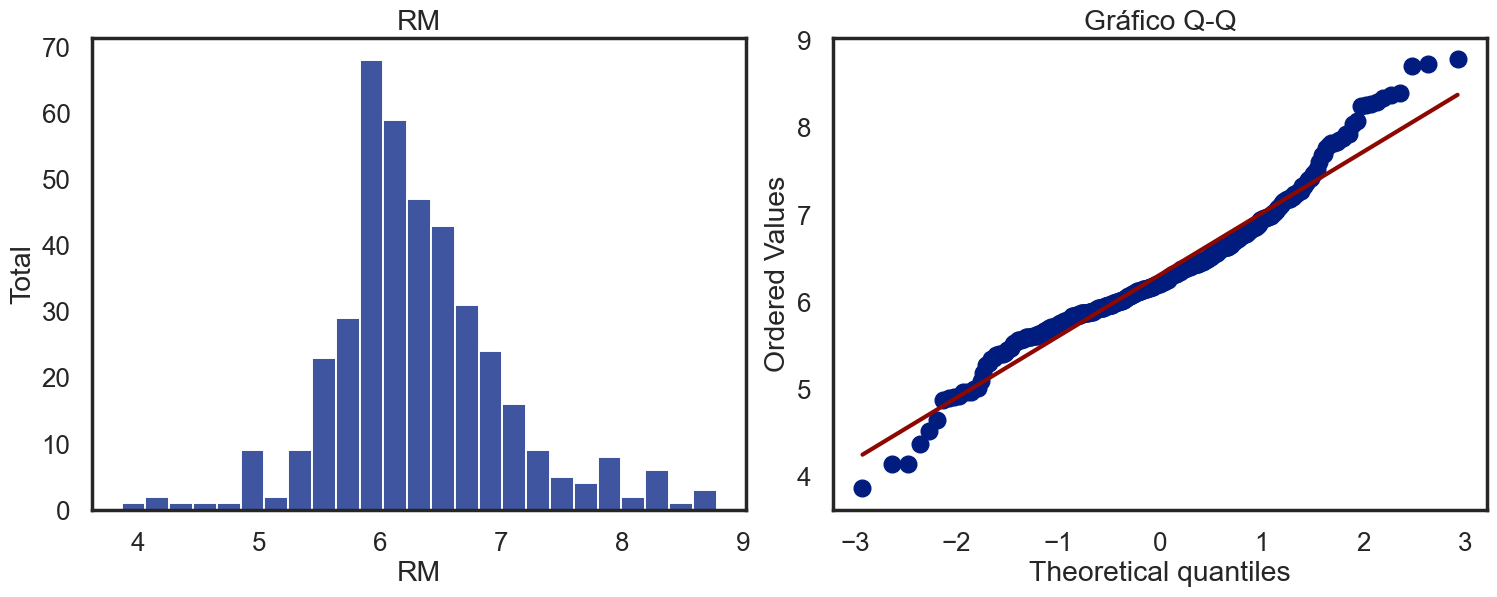

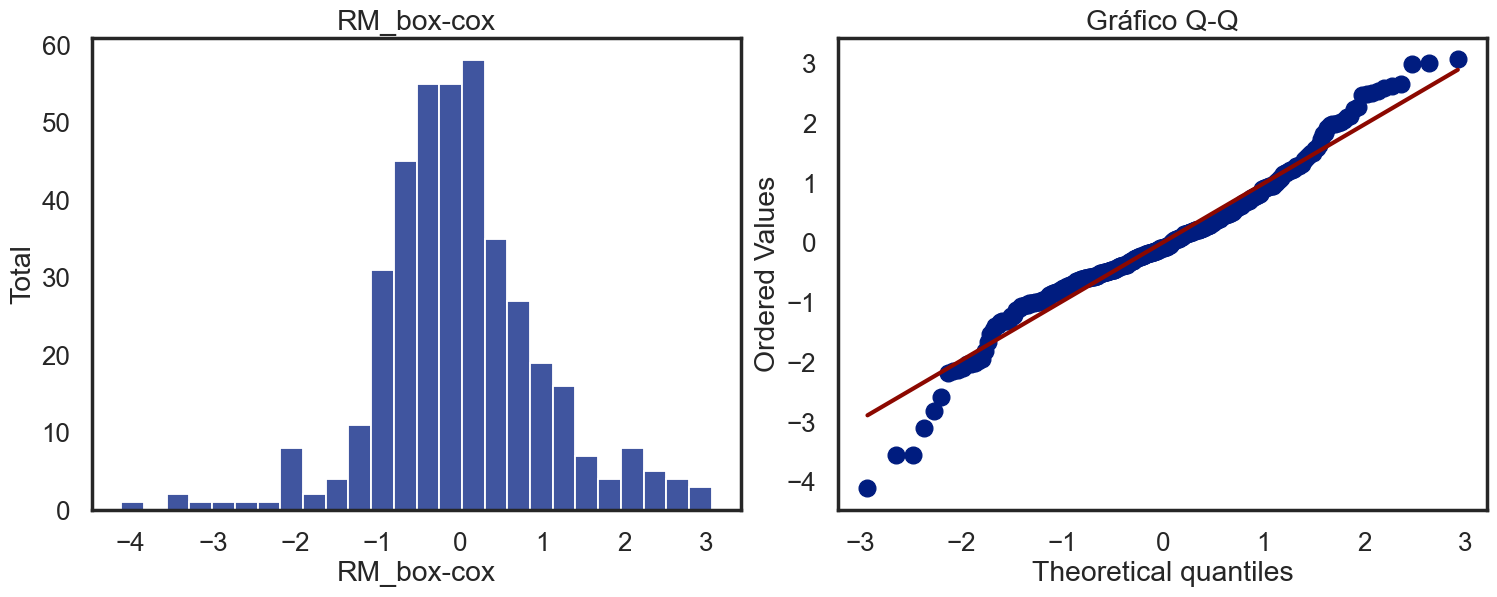

In [43]:
titulo=name+'_'+metodo
df_Power[titulo].shape
print(' 1. Fila Antes de la Transformación')
diagnostico_grafico(X_train,name)
print(' 2. Fila Después de la Transformación')
diagnostico_grafico(df_Power,titulo)
#crearquantile(df_Power)

### <font color='#d50283'>- Exercici 3</font>
Resumeix les noves columnes generades de manera estadística i gràfica.

In [27]:
def Resumen_Trans(df):
    sns.set(context='poster',
    style='white',
    palette='dark',
    font='sans-serif', 
    font_scale=0.85, color_codes='r', rc=None)
    rows = 3
    cols = 4

    fig, ax = plt.subplots(nrows = rows , ncols = cols , figsize = (20,15))

    col = df.columns
    index = 0
    #print(len(col))
    for i in range(rows):
        for j in range(cols):
            if index<=len(col)-1:
                sns.distplot(df[col[index]], ax = ax[i][j])
                index +=1 

                

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

>****Nota: la normalización es importante para algoritmos de aprendizaje automático, ya que ayuda a que los datos tengan una distribución similar y esto puede mejorar el rendimiento del modelo.****

**Resumen de la Transformación:**  

Transformación del atributo RM:

Nuevo Dataset con las transformaciones del atributo RM:



,Original,RM_std,RM_Rob,RM_Mx,RM_Nor,RM_Bin,RM_Po2,RM_Po3,RM_Po4
0,6.279,-0.046112,0.090120,0.491357,1.0,1.0,39.425841,247.554856,1554.396939
1,6.485,0.241629,0.365154,0.533252,1.0,1.0,42.055225,272.728134,1768.641950
2,5.935,-0.526610,-0.369159,0.421395,1.0,0.0,35.224225,209.055775,1240.746027
3,6.312,-0.000017,0.134179,0.498068,1.0,1.0,39.841344,251.478563,1587.332692
4,5.390,-1.287865,-1.096796,0.310555,1.0,0.0,29.052100,156.590819,844.024514
5,5.570,-1.036441,-0.856475,0.347163,1.0,0.0,31.024900,172.808693,962.544420
6,6.431,0.166202,0.293057,0.522270,1.0,1.0,41.357761,265.971761,1710.464395
7,6.037,-0.384137,-0.232977,0.442140,1.0,0.0,36.445369,220.020693,1328.264922
8,6.816,0.703969,0.807076,0.600569,1.0,1.0,46.457856,316.656746,2158.332384
9,5.985,-0.456770,-0.302403,0.431564,1.0,0.0,35.820225,214.384047,1283.088519


Estadística Descriptiva del atributo RM:



,Original,RM_std,RM_Rob,RM_Mx,RM_Nor,RM_Bin,RM_Po2,RM_Po3,RM_Po4
count,404.000000,4.040000e+02,404.000000,404.000000,404.0,404.00000,404.000000,404.000000,404.000000
mean,6.312012,3.918070e-16,0.134195,0.498070,1.0,0.50000,40.354046,261.372783,1715.809582
std,0.716811,1.001240e+00,0.957024,0.145782,0.0,0.50062,9.358275,94.099629,861.276383
min,3.863000,-3.420775e+00,-3.135514,0.000000,1.0,0.00000,14.922769,57.646657,222.689035
25%,5.887750,-5.926088e-01,-0.432243,0.411786,1.0,0.00000,34.665600,204.102390,1201.703867
50%,6.211500,-1.403955e-01,0.000000,0.477629,1.0,0.50000,38.582733,239.656646,1488.627286
75%,6.636750,4.535928e-01,0.567757,0.564114,1.0,1.00000,44.046460,292.325464,1940.092236
max,8.780000,3.447280e+00,3.429239,1.000000,1.0,1.00000,77.088400,676.836152,5942.621415


Gráficas del atributo RM:



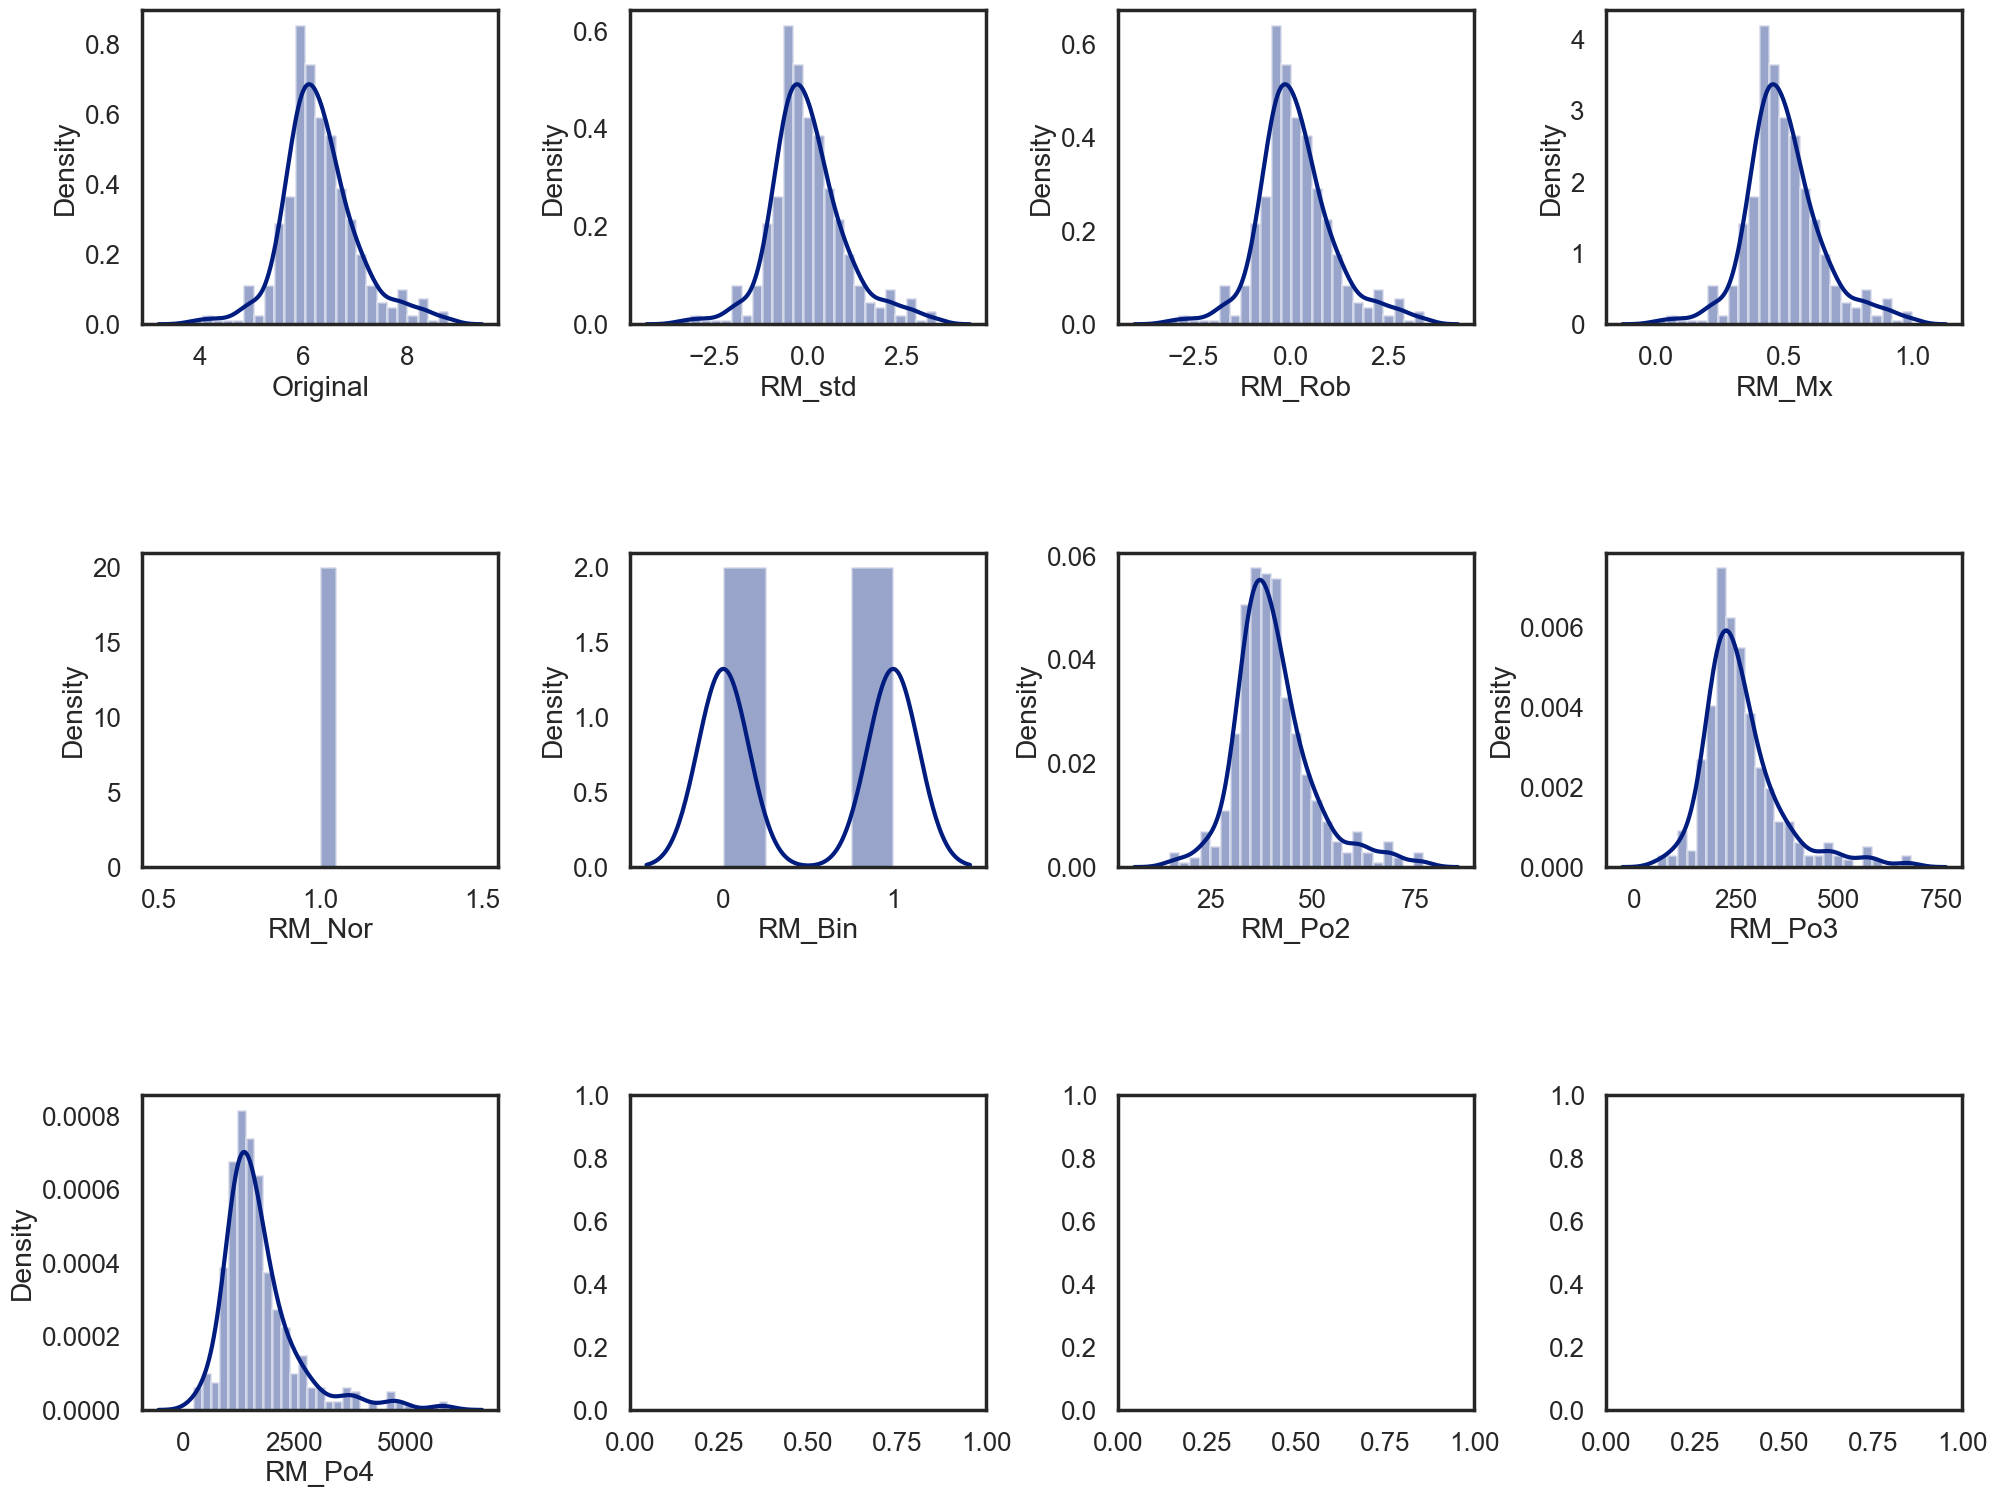

In [28]:
df_resultado = pd.concat([df_polynomial.iloc[:,1],df_standar,df_Robus,df_MinMax,df_normalized,df_binary,df_polynomial.iloc[:,2:5]], axis=1)
df_resultado = df_resultado.rename(columns={df_resultado.columns[0]: 'Original'})
df_resultado
print(Style.BRIGHT +f'Transformación del atributo {name}:\n'+Style.RESET_ALL)
print(Style.BRIGHT +f'Nuevo Dataset con las transformaciones del atributo {name}:\n'+Style.RESET_ALL)
display(df_resultado.head(10))
print(Style.BRIGHT +f'Estadística Descriptiva del atributo {name}:\n'+Style.RESET_ALL)
display(df_resultado.describe())
print(Style.BRIGHT +f'Gráficas del atributo {name}:\n'+Style.RESET_ALL)
Resumen_Trans(df_resultado)

***Continuación con dos atributos:***

In [29]:
# Dataset Original
#print(features)
atributo2 = ['RM']
target2 = ['MEDV']
lista=atributo2+target2
print(lista)
#features = columnas
#Voy a utilizar los atributos que han tenido un coeficiente de correlación +/- 0.7 y RM que parecia
#una distribución normal

x = data.loc[:, atributo2]
#target 
y= data.loc[:, target2]

x1=x
y1=y

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size =0.2, 
                                                    random_state = 42) 



['RM', 'MEDV']


 - Unimos nuestras columnas creadas anteriomente en un Dataset.

In [30]:
def Resumen(dfeat,dftar,titulo,Col):
    df1 = pd.DataFrame(dfeat)
    df2 = pd.DataFrame(dftar)
    df = pd.concat([df1,df2], axis="columns")
    df.columns =list(Col)
    print(Style.BRIGHT +f'Resultado de la Transformación {titulo}:'+Style.RESET_ALL)
    #display(df[:5])
    #print('- Estadística descriptiva:')
    #print(df.describe())
    return(df)

In [31]:
# Estudio de los atributos transformados
titulo='StandardScaler'

# define  StandardScaler()
standar = StandardScaler()
# transform data
standar_feat = standar.fit_transform(xtrain)
standar_targ = standar.fit_transform(ytrain)

df_standar=Resumen(standar_feat,standar_targ,titulo,lista)
print('- Estadística descriptiva:')
df_standar.describe().round(3)

Resultado de la Transformación StandardScaler:
- Estadística descriptiva:


,RM,MEDV
count,404.000,404.000
mean,0.000,0.000
std,1.001,1.001
min,-3.421,-1.871
25%,-0.593,-0.604
50%,-0.140,-0.154
75%,0.454,0.393
max,3.447,2.841


Gráfica StandardScaler: 


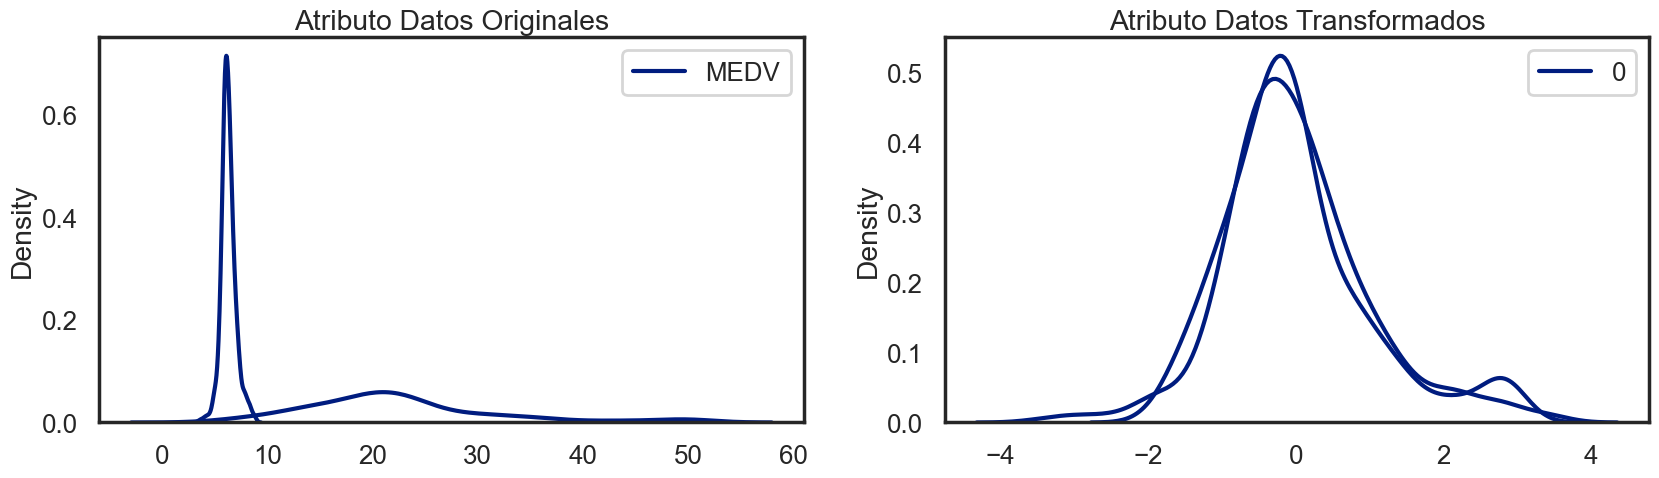

In [32]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,5))
print('Gráfica StandardScaler: ')
ax1.set_title('Atributo Datos Originales')

sns.kdeplot(x1,ax=ax1)
sns.kdeplot(y1,ax=ax1)


ax2.set_title('Atributo Datos Transformados')
sns.kdeplot(standar_feat ,ax=ax2)
sns.kdeplot(standar_targ, ax=ax2)

plt.show()


In [33]:
# Estudio de los atributos transformados
titulo='RobustScale'

# define RobustScaler()
Robus = RobustScaler()
# transform data
Robus_feat = Robus.fit_transform(xtrain)
Robus_targ = Robus.fit_transform(ytrain)

df_Robus=Resumen(Robus_feat,Robus_targ,titulo,lista)
print('- Estadística descriptiva:')
df_Robus.describe()

Resultado de la Transformación RobustScale:
- Estadística descriptiva:


,RM,MEDV
count,404.000000,404.000000
mean,0.134195,0.154232
std,0.957024,1.003977
min,-3.135514,-1.721785
25%,-0.432243,-0.451444
50%,0.000000,0.000000
75%,0.567757,0.548556
max,3.429239,3.002625


Gráfica RobustScaler: 


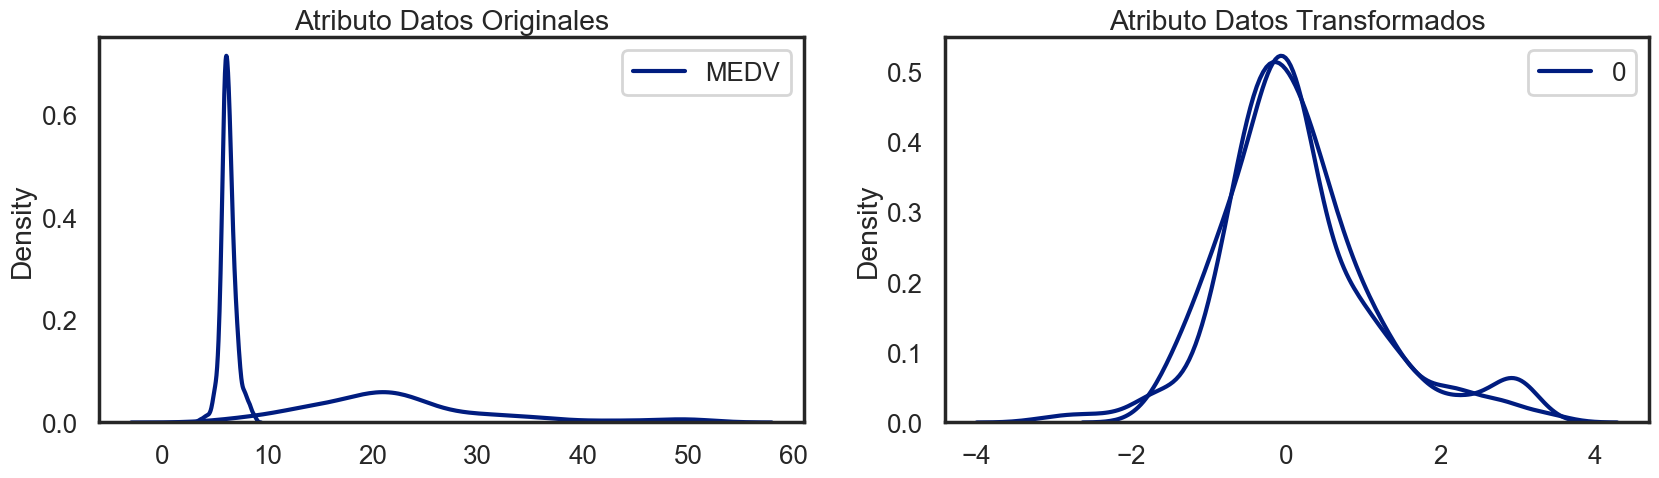

In [34]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,5))
print('Gráfica RobustScaler: ')
ax1.set_title('Atributo Datos Originales')

sns.kdeplot(x1,ax=ax1)
sns.kdeplot(y1,ax=ax1)


ax2.set_title('Atributo Datos Transformados')
sns.kdeplot(Robus_feat ,ax=ax2)
sns.kdeplot(Robus_targ, ax=ax2)

plt.show()

In [35]:
# Estudio de los atributos transformados
titulo='MinMaxScaler'

# define min max scaler
scaler = MinMaxScaler()
# transform data
scaler_feat = scaler.fit_transform(xtrain)
scaler_targ = scaler.fit_transform(ytrain)

df_MinMax=Resumen(scaler_feat,scaler_targ,titulo,lista)
print('- Estadística descriptiva:')
df_MinMax.describe()

Resultado de la Transformación MinMaxScaler:
- Estadística descriptiva:


,RM,MEDV
count,404.000000,404.000000
mean,0.498070,0.397090
std,0.145782,0.212509
min,0.000000,0.000000
25%,0.411786,0.268889
50%,0.477629,0.364444
75%,0.564114,0.480556
max,1.000000,1.000000


Gráfica Estandarizar: 


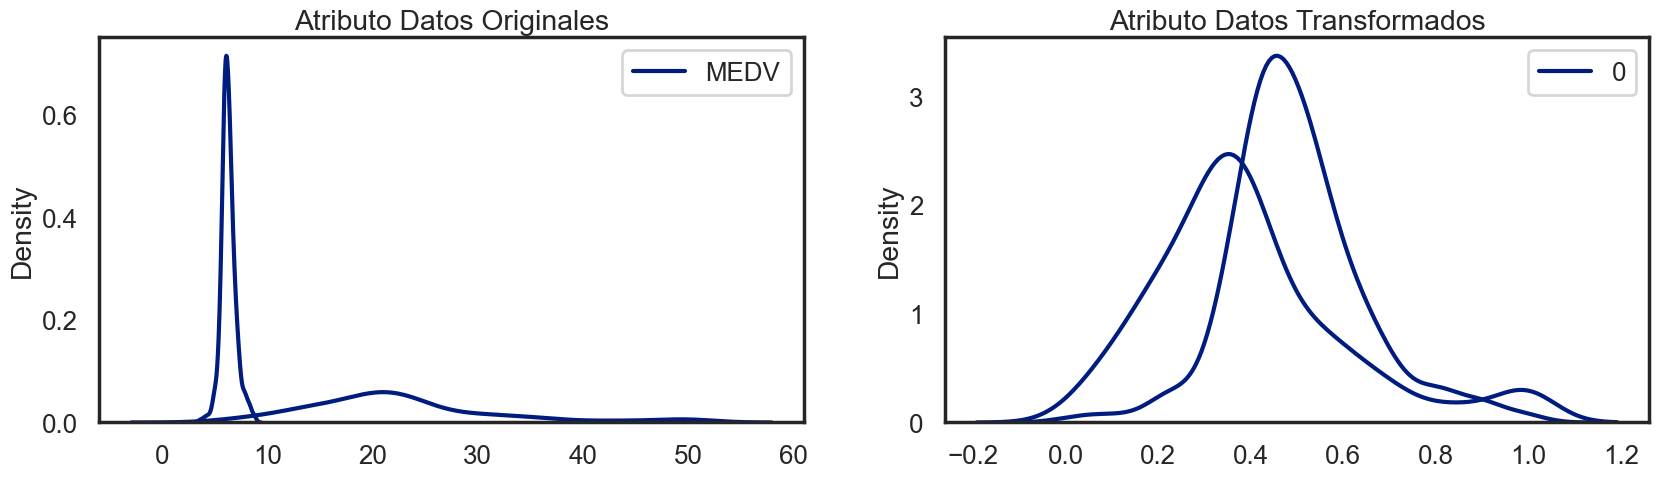

In [36]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,5))
print('Gráfica Estandarizar: ')
ax1.set_title('Atributo Datos Originales')
sns.kdeplot(x1,ax=ax1)
sns.kdeplot(y1,ax=ax1)


ax2.set_title('Atributo Datos Transformados')
sns.kdeplot(scaler_feat,ax=ax2)
sns.kdeplot(scaler_targ,ax=ax2)

plt.show()

In [37]:
# Estudio de los atributos transformados
titulo='Normalized'
# transform data
scaler_feat = Normalizer().fit(xtrain)
normalized_feat = scaler_feat.transform(xtrain) 
scaler_targ = Normalizer().fit(y_train)
normalized_targ = scaler_targ.transform(ytrain) 

df_normalized=Resumen(normalized_feat,normalized_targ,titulo,lista)
print('- Estadística descriptiva:')
df_normalized.describe()

Resultado de la Transformación Normalized:
- Estadística descriptiva:


,RM,MEDV
count,404.0,404.0
mean,1.0,1.0
std,0.0,0.0
min,1.0,1.0
25%,1.0,1.0
50%,1.0,1.0
75%,1.0,1.0
max,1.0,1.0


Gráfica Normalized:


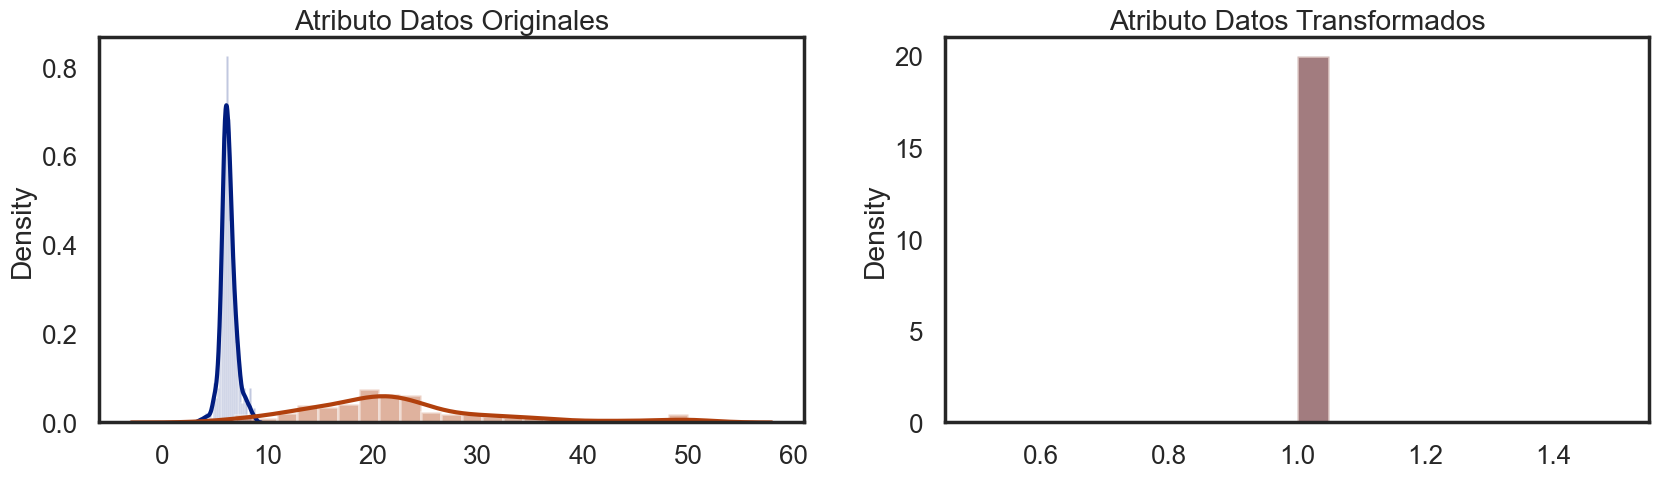

In [38]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,5))
print('Gráfica Normalized:')
ax1.set_title('Atributo Datos Originales')
sns.distplot(x1, ax=ax1)
sns.distplot(y1, ax=ax1)


ax2.set_title('Atributo Datos Transformados')
sns.distplot(normalized_feat, ax=ax2)
sns.distplot(normalized_targ, ax=ax2)
plt.show()

In [39]:
# Estudio de los atributos transformados
titulo='Binary'

# BINARIZACION
valor=np.median(xtrain)
binarizer = Binarizer(threshold=valor).fit(xtrain)
binary_feat = binarizer.transform(xtrain)

valor=np.median(ytrain)
binarizer = Binarizer(threshold=valor).fit(ytrain)
binary_targ = binarizer.transform(ytrain)

df_binarizer=Resumen(binary_feat,binary_targ,titulo,lista)
print('- Estadística descriptiva:')
df_binarizer.describe()

Resultado de la Transformación Binary:
- Estadística descriptiva:


,RM,MEDV
count,404.00000,404.000000
mean,0.50000,0.492574
std,0.50062,0.500565
min,0.00000,0.000000
25%,0.00000,0.000000
50%,0.50000,0.000000
75%,1.00000,1.000000
max,1.00000,1.000000


Gráfica Binary:


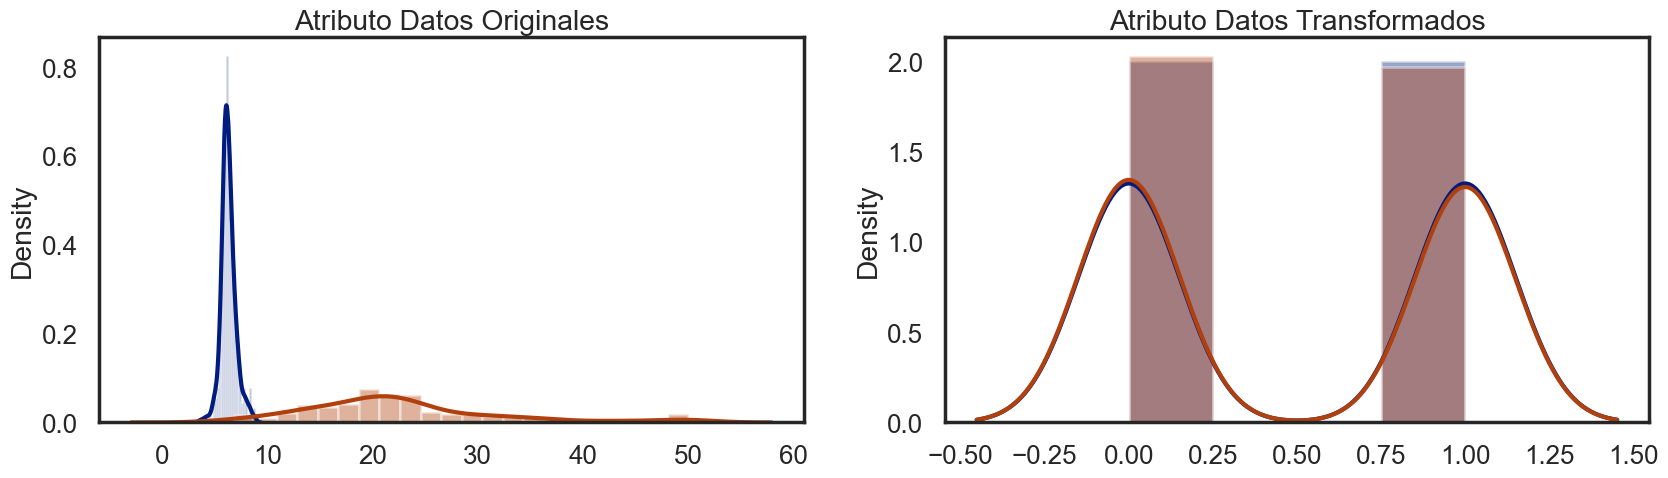

In [40]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,5))
print('Gráfica Binary:')
ax1.set_title('Atributo Datos Originales')
sns.distplot(x1, ax=ax1)
sns.distplot(y1, ax=ax1)


ax2.set_title('Atributo Datos Transformados')
sns.distplot(binary_feat, ax=ax2)
sns.distplot(binary_targ, ax=ax2)
plt.show()

In [41]:
# Estudio de los atributos transformados
grado=7
#df_polynomial_ytrain
name_xtrain='RM'

polynomial_feat=Polinomio(xtrain,grado,name_xtrain)
#df_polynomial_xtrain
name_ytrain='MEDV'
polynomial_targ=Polinomio(ytrain,grado,name_ytrain)
#df_polynomial_ytrain
_lista=list(polynomial_feat.columns.values)+ list(polynomial_targ.columns.values)

titulo='Polynomial'
#Resumen(polynomial_atributo,titulo)
df_polynomial=Resumen(polynomial_feat,polynomial_targ,titulo,_lista)
print('- Estadística descriptiva:')
df_polynomial.describe()

Entrada atributo RM:
Primeras filas:
        RM
75   6.279
442  6.485

Columnas nuevas, transformadas: 
[[1.00000000e+00 6.27900000e+00 3.94258410e+01 2.47554856e+02
  1.55439694e+03 9.76005838e+03 6.12834066e+04 3.84798510e+05]
 [1.00000000e+00 6.48500000e+00 4.20552250e+01 2.72728134e+02
  1.76864195e+03 1.14696430e+04 7.43806351e+04 4.82358419e+05]]
Entrada atributo MEDV:
Primeras filas:
     MEDV
75   20.0
442  15.4

Columnas nuevas, transformadas: 
[[1.00000000e+00 2.00000000e+01 4.00000000e+02 8.00000000e+03
  1.60000000e+05 3.20000000e+06 6.40000000e+07 1.28000000e+09]
 [1.00000000e+00 1.54000000e+01 2.37160000e+02 3.65226400e+03
  5.62448656e+04 8.66170930e+05 1.33390323e+07 2.05421098e+08]]
Resultado de la Transformación Polynomial:
- Estadística descriptiva:


,RM_Po0,RM_Po1,RM_Po2,RM_Po3,RM_Po4,RM_Po5,RM_Po6,RM_Po7,MEDV_Po0,MEDV_Po1,MEDV_Po2,MEDV_Po3,MEDV_Po4,MEDV_Po5,MEDV_Po6,MEDV_Po7
count,404.0,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,4.040000e+02,404.0,404.000000,404.000000,404.000000,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02
mean,1.0,6.312012,40.354046,261.372783,1715.809582,11422.015988,77148.554290,5.290006e+05,1.0,22.869059,614.216262,19133.808230,6.780733e+05,2.660461e+07,1.123533e+09,4.989023e+10
std,0.0,0.716811,9.358275,94.099629,861.276383,7550.183267,64780.329748,5.499135e+05,0.0,9.562884,549.143033,27555.569584,1.354775e+06,6.654647e+07,3.277121e+09,1.618220e+11
min,1.0,3.863000,14.922769,57.646657,222.689035,860.247741,3323.137023,1.283728e+04,1.0,5.000000,25.000000,125.000000,6.250000e+02,3.125000e+03,1.562500e+04,7.812500e+04
25%,1.0,5.887750,34.665600,204.102390,1201.703867,7075.332094,41657.787664,2.452706e+05,1.0,17.100000,292.410000,5000.211000,8.550361e+04,1.462112e+06,2.500211e+07,4.275361e+08
50%,1.0,6.211500,38.582733,239.656646,1488.627286,9246.608625,57435.311336,3.567595e+05,1.0,21.400000,457.960000,9800.344000,2.097274e+05,4.488166e+06,9.604674e+07,2.055400e+09
75%,1.0,6.636750,44.046460,292.325464,1940.092236,12875.917899,85454.337334,5.671398e+05,1.0,26.625000,708.892500,18874.362750,5.025339e+05,1.338011e+07,3.562501e+08,9.485310e+09
max,1.0,8.780000,77.088400,676.836152,5942.621415,52176.216020,458107.176654,4.022181e+06,1.0,50.000000,2500.000000,125000.000000,6.250000e+06,3.125000e+08,1.562500e+10,7.812500e+11


<font color='##08a22a'>*Ayuda:*</font>  
<font color='##08a22a'>*POLYNOMIAL REGRESSION*</font> [Link](<https://www.ellaberintodefalken.com/2019/12/regresion-polinomica-polinomial.html>)   
<font color='##08a22a'>*POLYNOMIAL REGRESSION*</font> [Video](<https://www.youtube.com/watch?v=K9ZqoV6recQ>) 

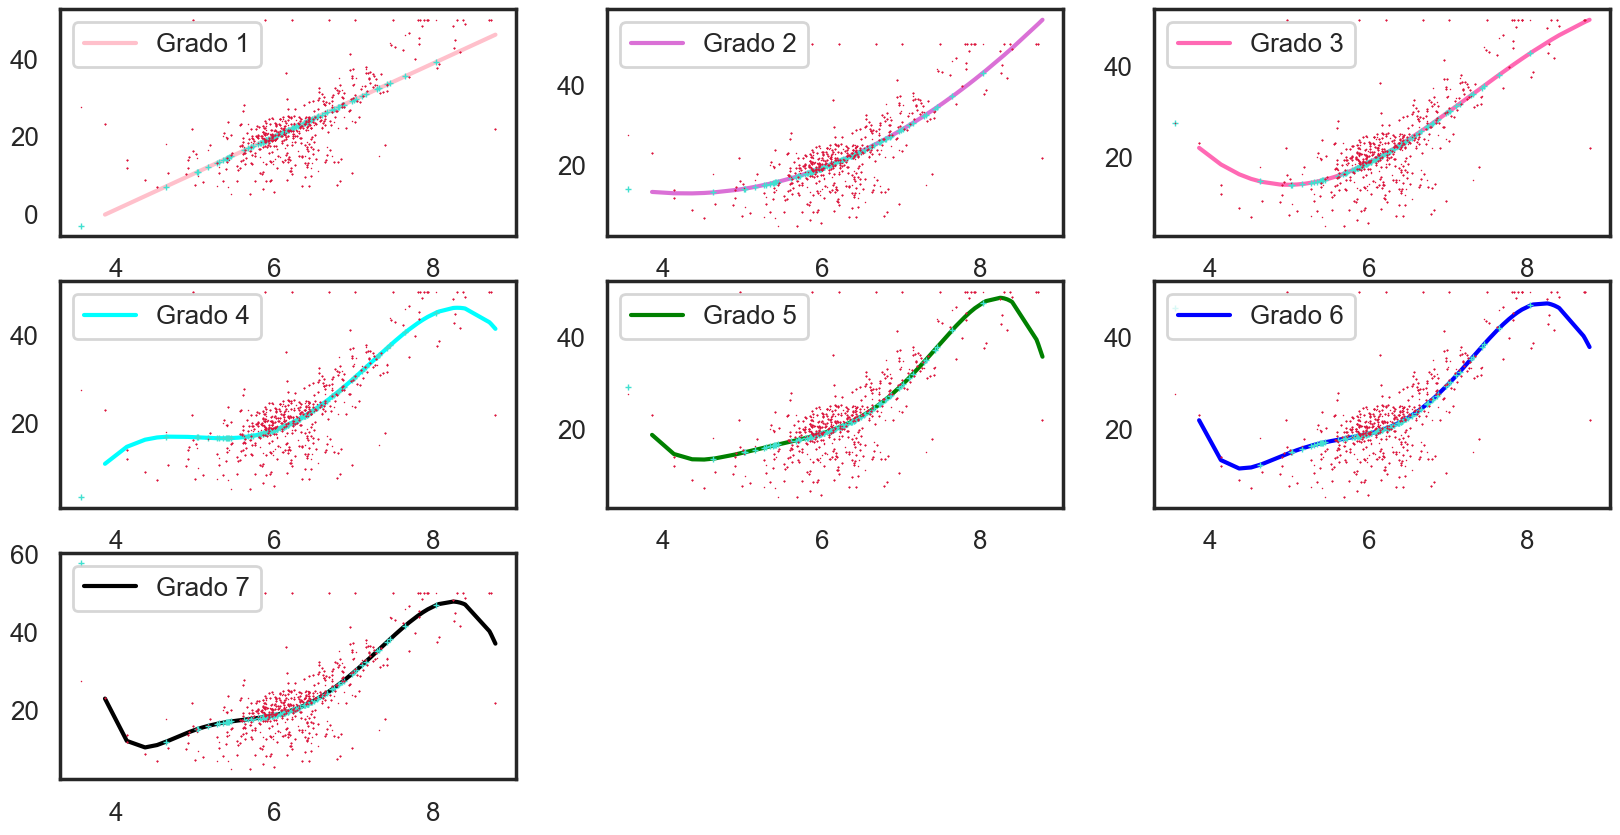

In [42]:

   
titles =['Grado 0','Grado 1','Grado 2','Grado 3','Grado 4','Grado 5','Grado 6','Grado 7']
colors =['teal','pink','orchid','hotpink','aqua','green','blue','black']
#polynominal = PolynomialFeatures(2)

fig = plt.subplots(ncols=2, figsize=(20,10))
for i in range (1,8):

    poly_features=PolynomialFeatures(degree=i,include_bias=False)
    X_poly=poly_features.fit_transform(xtrain.values.reshape(-1, 1))
    Xt_poly=poly_features.fit_transform(xtest.values.reshape(-1, 1))
    poly_model=LinearRegression()
    poly_model.fit(X_poly,ytrain.values.reshape(-1, 1))
    pred=poly_model.predict(X_poly)
    X,y=zip(*sorted(zip(xtrain.values.reshape(-1, 1),pred)))
    pred2=poly_model.predict(Xt_poly)
    xt,yt=zip(*sorted(zip(xtest.values.reshape(-1, 1),pred2)))

    plt.subplot(3,3,i)
    # lineas de regresión, xtrain e xtest
    plt.plot(X,y,'-',color=colors[i],label=titles[i],markersize=0.5)
    plt.plot(xt,yt,'+',color='turquoise',markersize=5)
    #Muesta general
    plt.plot(x1, y1,'*',color='crimson',markersize=.5) 
    # muestra conjunt de dades adjunt en train i test.
    plt.plot(xtrain, ytrain,'*',color='crimson',markersize=.9) 
    plt.legend(loc=2)



> Nota:
Se observa que cuanto más aumentamos el grado la linea de regresión mejora (Intenta recoger más elementos ).
